In [1]:
pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 499.4/499.4 kB 12.9 MB/s eta 0:00:0000:01
  Attempting uninstall: pytz
    Found existing installation: pytz 2022.1
    Uninstalling pytz-2022.1:
      Successfully uninstalled pytz-2022.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
beatrix-jupyterlab 3.1.7 requires google-cloud-bigquery-storage, which is not installed.
pandas-profiling 3.1.0 requires markupsafe~=2.0.1, but you have markupsafe 2.1.1 which is incompatible.
apache-beam 2.40.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.5.1 which is incompatible.
apache-beam 2.40.0 requires pyarrow<8.0.0,>=0.15.1, but you have pyarrow 8.0.0 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install yahooquery

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.4/46.4 kB 2.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Raw Package
import numpy as np
import pandas as pd

#Data Source
import yfinance as yf

#Data viz
import plotly.graph_objs as go

from re import search
from yahooquery import Screener

In [4]:
def getRates(ticker_input ,period_input  ,interval_input ):
    print(ticker_input+" "+period_input+" "+interval_input )
    data = yf.download(tickers=ticker_input, period = period_input, interval = interval_input)
    return data["Close"]

In [5]:
def getPercChange(d):
    x=round(d.head(1),6).values
    y=round(d.tail(1),6).values
    perc_chg= np.round( (  (y-x) / abs(x)  ) *100  , 4)
    return perc_chg

In [6]:
def mail2me(pair_text,message_text):
    from email.message import EmailMessage
    import smtplib
    from pretty_html_table import build_table

    sender = "ozukun83@gmail.com"
    recipient = "ozukun83@gmail.com"
    message = "Crypto Info all"

    password = input("Type your password and press enter: ")
    
    email = EmailMessage()
    email["From"] = sender
    email["To"] = recipient
    email["Subject"] = "Crypto Rates Python!"+"  "+pair_text
    email.set_content(message_text)

    
    
    smtp = smtplib.SMTP_SSL("smtp.gmail.com")
    smtp.login(sender, password)
    smtp.sendmail(sender, recipient, email.as_string())
    smtp.quit()
    print("Mail succeed !!")

In [7]:
# get all crypto pairs with USD
def getCryptoPairs():
    s = Screener()
    tickers=[]
    data = s.get_screeners('all_cryptocurrencies_us', count=100)

    # data is in the quotes key
    dicts = data['all_cryptocurrencies_us']['quotes']
    symbols = [d['symbol'] for d in dicts]
    symbols[0]

    for s in symbols:
        if  search("USD", s) and not search("USDT", s) and not search("USDC", s): #\
        #and ( search("ETH",s) or search("DOGE",s) ):
            #print(s+"\n")
            tickers.append(s)
             
    return tickers
        

#for cp in getCryptoPairs():
#    print(cp)

In [35]:
# moving average
def get_ma(prices, rate):
    return prices.rolling(rate).mean()



def get_bollinger_bands(prices, rate=7):
    sma = get_ma(prices, rate)
    std = prices.rolling(rate).std()
    bollinger_up = sma + std * 2 # Calculate top band
    bollinger_down = sma - std * 2 # Calculate bottom band
    return bollinger_up, bollinger_down


def get_macd(price, slow, fast, smooth):
    exp1 = price.ewm(span = fast, adjust = False).mean()
    exp2 = price.ewm(span = slow, adjust = False).mean()
    
    macd = pd.DataFrame(exp1 - exp2)
    macd.columns=["macd"]
    
    signal = pd.DataFrame(macd.ewm(span = smooth, adjust = False).mean())
    signal.columns=["signal"]
    
    hist = pd.DataFrame(macd['macd'] - signal['signal'])
    hist.columns=["hist"]
    
    
    
    frames =  [macd, signal, hist]
    
    
    
    df = pd.concat(frames, join = 'inner', axis = 1)
    df["result"]= np.select([df.macd > df.signal , df.macd < df.signal], ["Buy", "Sell"])
    return df




#HISTOGRAM = MACD LINE - SIGNAL LINE

#IF MACD LINE > SIGNAL LINE => BUY THE STOCK
#IF SIGNAL LINE > MACD LINE => SELL THE STOCK

#---------------------------------------------------------------


df_tmp_f = pd.DataFrame()
final_text=""
#Crypto_Pairs=["BTC-USD","ETH-USD","ALGO-USD","SOL-USD","LUNC-USD","ROSE-USD","SHIB-USD","XRP-USD","ADA-USD"]

Crypto_Pairs=[]
for cpx in getCryptoPairs():
    Crypto_Pairs.append(cpx)

for cp in Crypto_Pairs:

    df_tmp_0 = pd.DataFrame(getRates(cp,  '1y',  '1d'))

    bollinger_up, bollinger_down = get_bollinger_bands(df_tmp_0)

    cp_macd=get_macd(getRates(cp,  '1y',  '1d'), 26, 12, 9)
    
    #display(cp_macd.iloc[-7:])

    df_tmp = pd.DataFrame(data=np.column_stack((df_tmp_0.values,bollinger_up,bollinger_down,cp_macd.macd,
                                                cp_macd.signal,cp_macd.result )),
                          columns=['Price','Bol_Up','Bol_Down',"macd","signal","result"])
    df_tmp.insert(0,'Crypto_Pair',cp)
    df_tmp.index=df_tmp_0.index


    display( df_tmp.iloc[-7:] )
    
    x=round( df_tmp["Bol_Up"].iloc[-30:].mean() ,6 )
    print("Bol_Up__Mean_for_last_7days   : " + str( x ) )
    
    
    y=round( df_tmp["Bol_Down"].iloc[-30:].mean() ,6 )
    print("Bol_Down__Mean_for_last_7days : " + str( y ) )
    
    
    df_tmp_2 = pd.DataFrame(data=np.column_stack((x,y )),
                          columns=['Bol_Up_30','Bol_Down_30'])
    
    
    #display( df_tmp_2["Bol_Up_30"].values )
    
    x1="Bol_Up__Mean_for_last_7days   : " + str( x )
    y1="Bol_Down__Mean_for_last_7days : " + str( y )
    
    df_tmp_f = df_tmp_f.append(df_tmp.iloc[-7:])
    final_text=final_text+"\n"+cp+"\n"+str(x1)+"\n"+str(y1)
    
    if df_tmp.iloc[-1].Price<df_tmp_2["Bol_Up_30"].values :
        print("BUY_signal")
#---------------------------------------------------------------------------
#mail2me_v2(df_tmp_f,"Crypto Bollinger bands",final_text)

BTC-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
BTC-USD 1y 1d
[*********************100%***********************]  1 of 1 completed


,Crypto_Pair,Price,Bol_Up,Bol_Down,macd,signal,result
Date,,,,,,,
2023-01-08,BTC-USD,17091.144531,17164.458981,16568.825059,-15.72705,-74.442695,Buy
2023-01-09,BTC-USD,17196.554688,17279.089426,16599.361467,13.207424,-56.912671,Buy
2023-01-10,BTC-USD,17446.292969,17480.139736,16617.292741,55.648513,-34.400435,Buy
2023-01-11,BTC-USD,17934.896484,17961.651582,16441.968954,127.242826,-2.071782,Buy
2023-01-12,BTC-USD,18869.587891,18888.375787,16096.059481,256.447454,49.632065,Buy
2023-01-13,BTC-USD,19909.574219,20109.574762,15719.890639,437.715545,127.248761,Buy
2023-01-14,BTC-USD,21034.111328,21515.028391,15479.875069,664.453157,234.68964,Buy


Bol_Up__Mean_for_last_7days   : 17560.73574
Bol_Down__Mean_for_last_7days : 16376.827597
ETH-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
ETH-USD 1y 1d
[*********************100%***********************]  1 of 1 completed


,Crypto_Pair,Price,Bol_Up,Bol_Down,macd,signal,result
Date,,,,,,,
2023-01-08,ETH-USD,1287.359497,1305.828059,1196.288955,7.442582,-2.889198,Buy
2023-01-09,ETH-USD,1321.53894,1332.205954,1200.448866,13.161297,0.320901,Buy
2023-01-10,ETH-USD,1336.58606,1350.408883,1217.048009,18.692126,3.995146,Buy
2023-01-11,ETH-USD,1387.932739,1400.211958,1204.789542,26.908412,8.577799,Buy
2023-01-12,ETH-USD,1417.938477,1444.549557,1208.30905,35.432644,13.948768,Buy
2023-01-13,ETH-USD,1451.614868,1490.547538,1214.378453,44.393819,20.037778,Buy
2023-01-14,ETH-USD,1551.258423,1573.418092,1213.50448,58.857543,27.801731,Buy


Bol_Up__Mean_for_last_7days   : 1304.005179
Bol_Down__Mean_for_last_7days : 1175.486722
BNB-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
BNB-USD 1y 1d
[*********************100%***********************]  1 of 1 completed


,Crypto_Pair,Price,Bol_Up,Bol_Down,macd,signal,result
Date,,,,,,,
2023-01-08,BNB-USD,274.385071,277.218321,237.852214,-0.748207,-5.001504,Buy
2023-01-09,BNB-USD,272.701538,280.76791,242.064235,0.620445,-3.877114,Buy
2023-01-10,BNB-USD,277.289642,283.022649,248.71129,2.051683,-2.691354,Buy
2023-01-11,BNB-USD,285.046509,290.670191,248.471411,3.768424,-1.399399,Buy
2023-01-12,BNB-USD,287.812347,295.454464,252.655565,5.291141,-0.061291,Buy
2023-01-13,BNB-USD,293.733002,300.633742,257.152242,6.896157,1.330199,Buy
2023-01-14,BNB-USD,305.807465,308.918754,261.588553,9.038265,2.871812,Buy


Bol_Up__Mean_for_last_7days   : 268.581303
Bol_Down__Mean_for_last_7days : 239.315709
XRP-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
XRP-USD 1y 1d
[*********************100%***********************]  1 of 1 completed


,Crypto_Pair,Price,Bol_Up,Bol_Down,macd,signal,result
Date,,,,,,,
2023-01-08,XRP-USD,0.345358,0.35148,0.337801,-0.007835,-0.009062,Buy
2023-01-09,XRP-USD,0.34934,0.35191,0.337595,-0.007011,-0.008652,Buy
2023-01-10,XRP-USD,0.351241,0.354384,0.33724,-0.006134,-0.008148,Buy
2023-01-11,XRP-USD,0.374158,0.372823,0.326334,-0.003549,-0.007228,Buy
2023-01-12,XRP-USD,0.375197,0.382411,0.327362,-0.0014,-0.006063,Buy
2023-01-13,XRP-USD,0.385804,0.394878,0.326655,0.001145,-0.004621,Buy
2023-01-14,XRP-USD,0.395824,0.40748,0.328783,0.003926,-0.002912,Buy


Bol_Up__Mean_for_last_7days   : 0.373302
Bol_Down__Mean_for_last_7days : 0.334113
BUSD-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
BUSD-USD 1y 1d
[*********************100%***********************]  1 of 1 completed


,Crypto_Pair,Price,Bol_Up,Bol_Down,macd,signal,result
Date,,,,,,,
2023-01-08,BUSD-USD,1.000978,1.000945,0.999715,0.00008,0.000031,Buy
2023-01-09,BUSD-USD,0.999786,1.001014,0.999555,0.00003,0.00003,Sell
2023-01-10,BUSD-USD,1.000235,1.001008,0.999547,0.000025,0.000029,Sell
2023-01-11,BUSD-USD,1.000029,1.000981,0.999483,0.000005,0.000025,Sell
2023-01-12,BUSD-USD,1.000319,1.001002,0.999544,0.000013,0.000022,Sell
2023-01-13,BUSD-USD,1.000313,1.001006,0.999547,0.000018,0.000021,Sell
2023-01-14,BUSD-USD,1.000247,1.001003,0.999542,0.000017,0.00002,Sell


Bol_Up__Mean_for_last_7days   : 1.000698
Bol_Down__Mean_for_last_7days : 0.999662
BUY_signal
ADA-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
ADA-USD 1y 1d
[*********************100%***********************]  1 of 1 completed


,Crypto_Pair,Price,Bol_Up,Bol_Down,macd,signal,result
Date,,,,,,,
2023-01-08,ADA-USD,0.295218,0.300316,0.240935,-0.003113,-0.009818,Buy
2023-01-09,ADA-USD,0.317102,0.321523,0.237806,0.000956,-0.007663,Buy
2023-01-10,ADA-USD,0.322496,0.334691,0.244553,0.004563,-0.005218,Buy
2023-01-11,ADA-USD,0.322749,0.343889,0.251089,0.007358,-0.002703,Buy
2023-01-12,ADA-USD,0.329758,0.350421,0.261888,0.010023,-0.000158,Buy
2023-01-13,ADA-USD,0.345771,0.361268,0.270218,0.013273,0.002529,Buy
2023-01-14,ADA-USD,0.351965,0.364097,0.288777,0.016163,0.005256,Buy


Bol_Up__Mean_for_last_7days   : 0.297127
Bol_Down__Mean_for_last_7days : 0.246117
DOGE-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
DOGE-USD 1y 1d
[*********************100%***********************]  1 of 1 completed


,Crypto_Pair,Price,Bol_Up,Bol_Down,macd,signal,result
Date,,,,,,,
2023-01-08,DOGE-USD,0.073601,0.074314,0.069972,-0.003289,-0.004131,Buy
2023-01-09,DOGE-USD,0.075784,0.076145,0.069378,-0.0028,-0.003865,Buy
2023-01-10,DOGE-USD,0.077729,0.0782,0.069398,-0.00223,-0.003538,Buy
2023-01-11,DOGE-USD,0.078153,0.079932,0.06907,-0.001724,-0.003175,Buy
2023-01-12,DOGE-USD,0.080286,0.081972,0.069526,-0.001138,-0.002768,Buy
2023-01-13,DOGE-USD,0.084438,0.08572,0.069198,-0.000335,-0.002281,Buy
2023-01-14,DOGE-USD,0.087282,0.089238,0.069983,0.000525,-0.00172,Buy


Bol_Up__Mean_for_last_7days   : 0.081746
Bol_Down__Mean_for_last_7days : 0.069547
SOL-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
SOL-USD 1y 1d
[*********************100%***********************]  1 of 1 completed


,Crypto_Pair,Price,Bol_Up,Bol_Down,macd,signal,result
Date,,,,,,,
2023-01-08,SOL-USD,14.319933,15.064974,11.33774,0.062595,-0.462099,Buy
2023-01-09,SOL-USD,16.302464,16.155043,11.68467,0.355272,-0.298625,Buy
2023-01-10,SOL-USD,16.196724,17.057964,11.5968,0.572094,-0.124481,Buy
2023-01-11,SOL-USD,16.359415,17.722329,11.76795,0.748427,0.050101,Buy
2023-01-12,SOL-USD,16.619043,18.211852,12.192631,0.898762,0.219833,Buy
2023-01-13,SOL-USD,18.288445,19.255113,12.510114,1.139475,0.403761,Buy
2023-01-14,SOL-USD,24.426487,24.029692,10.973882,1.804727,0.683954,Buy


Bol_Up__Mean_for_last_7days   : 14.561535
Bol_Down__Mean_for_last_7days : 10.519008
MATIC-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
MATIC-USD 1y 1d
[*********************100%***********************]  1 of 1 completed


,Crypto_Pair,Price,Bol_Up,Bol_Down,macd,signal,result
Date,,,,,,,
2023-01-08,MATIC-USD,0.840371,0.842028,0.758586,-0.011141,-0.02029,Buy
2023-01-09,MATIC-USD,0.844234,0.858271,0.760453,-0.006785,-0.017589,Buy
2023-01-10,MATIC-USD,0.858464,0.873875,0.767245,-0.00216,-0.014503,Buy
2023-01-11,MATIC-USD,0.893428,0.907336,0.758657,0.004277,-0.010747,Buy
2023-01-12,MATIC-USD,0.916289,0.936562,0.765934,0.011095,-0.006379,Buy
2023-01-13,MATIC-USD,0.931102,0.959912,0.780266,0.017492,-0.001605,Buy
2023-01-14,MATIC-USD,0.998406,1.010918,0.784023,0.027674,0.004251,Buy


Bol_Up__Mean_for_last_7days   : 0.865288
Bol_Down__Mean_for_last_7days : 0.760724
DOT-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
DOT-USD 1y 1d
[*********************100%***********************]  1 of 1 completed


,Crypto_Pair,Price,Bol_Up,Bol_Down,macd,signal,result
Date,,,,,,,
2023-01-08,DOT-USD,4.801005,4.838459,4.422872,-0.083911,-0.162116,Buy
2023-01-09,DOT-USD,4.894874,4.935062,4.442125,-0.053954,-0.140484,Buy
2023-01-10,DOT-USD,4.918806,4.996498,4.493388,-0.02796,-0.117979,Buy
2023-01-11,DOT-USD,5.129979,5.176268,4.456414,0.00957,-0.092469,Buy
2023-01-12,DOT-USD,5.229478,5.329619,4.477867,0.046803,-0.064615,Buy
2023-01-13,DOT-USD,5.401746,5.522074,4.489881,0.089182,-0.033855,Buy
2023-01-14,DOT-USD,6.040129,6.052238,4.352338,0.172294,0.007375,Buy


Bol_Up__Mean_for_last_7days   : 4.967841
Bol_Down__Mean_for_last_7days : 4.336684
LTC-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
LTC-USD 1y 1d
[*********************100%***********************]  1 of 1 completed


,Crypto_Pair,Price,Bol_Up,Bol_Down,macd,signal,result
Date,,,,,,,
2023-01-08,LTC-USD,77.682274,77.95429,73.531035,1.706655,0.702376,Buy
2023-01-09,LTC-USD,81.747314,81.614782,71.837517,2.220254,1.005952,Buy
2023-01-10,LTC-USD,80.88752,83.132854,71.829387,2.528756,1.310513,Buy
2023-01-11,LTC-USD,84.070312,85.855581,71.574204,2.995541,1.647518,Buy
2023-01-12,LTC-USD,85.964226,88.113018,72.663458,3.4782,2.013655,Buy
2023-01-13,LTC-USD,86.340034,89.625943,74.10695,3.846692,2.380262,Buy
2023-01-14,LTC-USD,87.799866,90.649326,76.348259,4.208014,2.745813,Buy


Bol_Up__Mean_for_last_7days   : 77.127852
Bol_Down__Mean_for_last_7days : 65.823476
WTRX-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
WTRX-USD 1y 1d
[*********************100%***********************]  1 of 1 completed


,Crypto_Pair,Price,Bol_Up,Bol_Down,macd,signal,result
Date,,,,,,,
2023-01-08,WTRX-USD,0.053452,0.056182,0.051352,-0.000299,-0.000088,Sell
2023-01-09,WTRX-USD,0.054576,0.055888,0.05147,-0.000212,-0.000113,Sell
2023-01-10,WTRX-USD,0.054717,0.055761,0.051525,-0.000131,-0.000117,Sell
2023-01-11,WTRX-USD,0.056127,0.056683,0.051073,0.000047,-0.000084,Buy
2023-01-12,WTRX-USD,0.056888,0.057927,0.050729,0.000246,-0.000018,Buy
2023-01-13,WTRX-USD,0.059788,0.060436,0.050285,0.000631,0.000112,Buy
2023-01-14,WTRX-USD,0.06149,0.062598,0.050841,0.001061,0.000302,Buy


Bol_Up__Mean_for_last_7days   : 0.056331
Bol_Down__Mean_for_last_7days : 0.05262
DAI-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
DAI-USD 1y 1d
[*********************100%***********************]  1 of 1 completed


,Crypto_Pair,Price,Bol_Up,Bol_Down,macd,signal,result
Date,,,,,,,
2023-01-08,DAI-USD,1.000377,1.00048,0.999238,0.000032,-0.000006,Buy
2023-01-09,DAI-USD,0.9999,1.000464,0.999357,0.000029,0.000001,Buy
2023-01-10,DAI-USD,0.999722,1.000464,0.999324,0.000012,0.000003,Buy
2023-01-11,DAI-USD,1.000547,1.000716,0.99921,0.000065,0.000016,Buy
2023-01-12,DAI-USD,1.00006,1.000685,0.999394,0.000067,0.000026,Buy
2023-01-13,DAI-USD,1.000745,1.000936,0.999448,0.000122,0.000045,Buy
2023-01-14,DAI-USD,1.000354,1.000973,0.999514,0.000132,0.000062,Buy


Bol_Up__Mean_for_last_7days   : 1.000388
Bol_Down__Mean_for_last_7days : 0.99929
BUY_signal
SHIB-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
SHIB-USD 1y 1d
[*********************100%***********************]  1 of 1 completed


,Crypto_Pair,Price,Bol_Up,Bol_Down,macd,signal,result
Date,,,,,,,
2023-01-08,SHIB-USD,0.000009,0.000009,0.000007,-0.0,-0.0,Buy
2023-01-09,SHIB-USD,0.000009,0.000009,0.000007,-0.0,-0.0,Buy
2023-01-10,SHIB-USD,0.000009,0.000009,0.000007,0.0,-0.0,Buy
2023-01-11,SHIB-USD,0.000009,0.00001,0.000008,0.0,-0.0,Buy
2023-01-12,SHIB-USD,0.000009,0.00001,0.000008,0.0,-0.0,Buy
2023-01-13,SHIB-USD,0.00001,0.00001,0.000008,0.0,0.0,Buy
2023-01-14,SHIB-USD,0.00001,0.000011,0.000008,0.0,0.0,Buy


Bol_Up__Mean_for_last_7days   : 9e-06
Bol_Down__Mean_for_last_7days : 8e-06
TRX-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
TRX-USD 1y 1d
[*********************100%***********************]  1 of 1 completed


,Crypto_Pair,Price,Bol_Up,Bol_Down,macd,signal,result
Date,,,,,,,
2023-01-08,TRX-USD,0.053815,0.05622,0.051411,-0.000274,-0.000085,Sell
2023-01-09,TRX-USD,0.054626,0.055975,0.051505,-0.000191,-0.000106,Sell
2023-01-10,TRX-USD,0.054782,0.055951,0.051515,-0.000111,-0.000107,Sell
2023-01-11,TRX-USD,0.056486,0.056986,0.050981,0.000089,-0.000068,Buy
2023-01-12,TRX-USD,0.057111,0.058262,0.05069,0.000294,0.000004,Buy
2023-01-13,TRX-USD,0.060011,0.060723,0.050377,0.000683,0.00014,Buy
2023-01-14,TRX-USD,0.061812,0.062903,0.050995,0.001123,0.000337,Buy


Bol_Up__Mean_for_last_7days   : 0.056378
Bol_Down__Mean_for_last_7days : 0.052633
AVAX-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
AVAX-USD 1y 1d
[*********************100%***********************]  1 of 1 completed


,Crypto_Pair,Price,Bol_Up,Bol_Down,macd,signal,result
Date,,,,,,,
2023-01-08,AVAX-USD,12.072585,12.38543,11.029738,-0.220526,-0.379343,Buy
2023-01-09,AVAX-USD,12.209637,12.421221,11.295668,-0.15987,-0.335448,Buy
2023-01-10,AVAX-USD,12.731241,12.75939,11.342296,-0.068916,-0.282142,Buy
2023-01-11,AVAX-USD,15.913924,15.607017,9.590758,0.257018,-0.17431,Buy
2023-01-12,AVAX-USD,15.45735,16.692009,9.56781,0.473029,-0.044842,Buy
2023-01-13,AVAX-USD,15.962223,17.620659,9.833737,0.677153,0.099557,Buy
2023-01-14,AVAX-USD,16.985746,18.59883,10.353371,0.911011,0.261848,Buy


Bol_Up__Mean_for_last_7days   : 13.196323
Bol_Down__Mean_for_last_7days : 10.826181
STETH-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
STETH-USD 1y 1d
[*********************100%***********************]  1 of 1 completed


,Crypto_Pair,Price,Bol_Up,Bol_Down,macd,signal,result
Date,,,,,,,
2023-01-08,STETH-USD,1259.11145,1280.306004,1168.380938,6.95487,-3.094596,Buy
2023-01-09,STETH-USD,1291.087769,1303.163346,1175.539989,12.397041,0.003732,Buy
2023-01-10,STETH-USD,1315.637817,1324.154507,1191.8095,18.477981,3.698582,Buy
2023-01-11,STETH-USD,1347.883423,1364.925335,1182.754039,25.603975,8.07966,Buy
2023-01-12,STETH-USD,1393.512207,1417.043839,1175.372316,34.535138,13.370756,Buy
2023-01-13,STETH-USD,1422.381958,1460.636435,1186.790358,43.441925,19.38499,Buy
2023-01-14,STETH-USD,1510.100708,1535.117533,1190.515419,56.92262,26.892516,Buy


Bol_Up__Mean_for_last_7days   : 1273.397864
Bol_Down__Mean_for_last_7days : 1154.150894
UNI7083-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
UNI7083-USD 1y 1d
[*********************100%***********************]  1 of 1 completed


,Crypto_Pair,Price,Bol_Up,Bol_Down,macd,signal,result
Date,,,,,,,
2023-01-08,UNI7083-USD,5.570155,5.622017,5.279589,-0.034488,-0.098619,Buy
2023-01-09,UNI7083-USD,5.797958,5.807819,5.216913,0.000664,-0.078762,Buy
2023-01-10,UNI7083-USD,5.787434,5.902941,5.237791,0.027358,-0.057538,Buy
2023-01-11,UNI7083-USD,5.922764,6.047867,5.206241,0.058756,-0.034279,Buy
2023-01-12,UNI7083-USD,6.173381,6.262438,5.220798,0.102678,-0.006888,Buy
2023-01-13,UNI7083-USD,6.297109,6.474691,5.230311,0.14579,0.023648,Buy
2023-01-14,UNI7083-USD,6.620143,6.743196,5.305074,0.203675,0.059653,Buy


Bol_Up__Mean_for_last_7days   : 5.761725
Bol_Down__Mean_for_last_7days : 5.072539
HEX-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
HEX-USD 1y 1d
[*********************100%***********************]  1 of 1 completed


,Crypto_Pair,Price,Bol_Up,Bol_Down,macd,signal,result
Date,,,,,,,
2023-01-08,HEX-USD,0.023241,0.026667,0.015818,-0.001051,-0.00183,Buy
2023-01-09,HEX-USD,0.024632,0.027439,0.016813,-0.000732,-0.001611,Buy
2023-01-10,HEX-USD,0.021772,0.026615,0.018716,-0.000703,-0.001429,Buy
2023-01-11,HEX-USD,0.021143,0.02581,0.020113,-0.000721,-0.001288,Buy
2023-01-12,HEX-USD,0.024768,0.026286,0.020513,-0.000439,-0.001118,Buy
2023-01-13,HEX-USD,0.026132,0.02713,0.020133,-0.000104,-0.000915,Buy
2023-01-14,HEX-USD,0.025842,0.027814,0.020051,0.000137,-0.000705,Buy


Bol_Up__Mean_for_last_7days   : 0.025647
Bol_Down__Mean_for_last_7days : 0.01972
WBTC-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
WBTC-USD 1y 1d
[*********************100%***********************]  1 of 1 completed


,Crypto_Pair,Price,Bol_Up,Bol_Down,macd,signal,result
Date,,,,,,,
2023-01-08,WBTC-USD,17086.195312,17157.125899,16537.844525,-8.791282,-70.867218,Buy
2023-01-09,WBTC-USD,17189.605469,17274.604202,16571.951602,21.204676,-52.452839,Buy
2023-01-10,WBTC-USD,17414.423828,17459.917982,16602.114942,62.398361,-29.482599,Buy
2023-01-11,WBTC-USD,17883.585938,17916.203182,16442.376617,131.387561,2.691433,Buy
2023-01-12,WBTC-USD,18809.291016,18822.851251,16106.178325,257.787053,53.710557,Buy
2023-01-13,WBTC-USD,19813.568359,20008.37008,15742.922331,433.993543,129.767154,Buy
2023-01-14,WBTC-USD,21008.923828,21444.339888,15471.544041,662.457257,236.305175,Buy


Bol_Up__Mean_for_last_7days   : 17529.818982
Bol_Down__Mean_for_last_7days : 16336.375158
ATOM-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
ATOM-USD 1y 1d
[*********************100%***********************]  1 of 1 completed


,Crypto_Pair,Price,Bol_Up,Bol_Down,macd,signal,result
Date,,,,,,,
2023-01-08,ATOM-USD,10.53848,10.612356,9.736814,0.199718,0.035479,Buy
2023-01-09,ATOM-USD,11.126633,11.096265,9.631251,0.280899,0.084563,Buy
2023-01-10,ATOM-USD,11.32878,11.53065,9.530512,0.357426,0.139135,Buy
2023-01-11,ATOM-USD,11.834738,12.108008,9.420689,0.453672,0.202043,Buy
2023-01-12,ATOM-USD,12.274692,12.675427,9.481321,0.559004,0.273435,Buy
2023-01-13,ATOM-USD,12.399484,13.063885,9.706855,0.645113,0.347771,Buy
2023-01-14,ATOM-USD,12.874282,13.401109,10.135202,0.743102,0.426837,Buy


Bol_Up__Mean_for_last_7days   : 10.296542
Bol_Down__Mean_for_last_7days : 8.947729
LINK-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
LINK-USD 1y 1d
[*********************100%***********************]  1 of 1 completed


,Crypto_Pair,Price,Bol_Up,Bol_Down,macd,signal,result
Date,,,,,,,
2023-01-08,LINK-USD,5.933166,5.971327,5.524316,-0.176713,-0.236917,Buy
2023-01-09,LINK-USD,6.072278,6.124687,5.480857,-0.140463,-0.217626,Buy
2023-01-10,LINK-USD,6.153703,6.248924,5.508507,-0.103967,-0.194894,Buy
2023-01-11,LINK-USD,6.285186,6.418018,5.476886,-0.063699,-0.168655,Buy
2023-01-12,LINK-USD,6.381332,6.537878,5.566596,-0.023754,-0.139675,Buy
2023-01-13,LINK-USD,6.601779,6.7123,5.64674,0.025397,-0.106661,Buy
2023-01-14,LINK-USD,6.862466,6.968456,5.685804,0.084413,-0.068446,Buy


Bol_Up__Mean_for_last_7days   : 6.320314
Bol_Down__Mean_for_last_7days : 5.579115
LEO-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
LEO-USD 1y 1d
[*********************100%***********************]  1 of 1 completed


,Crypto_Pair,Price,Bol_Up,Bol_Down,macd,signal,result
Date,,,,,,,
2023-01-08,LEO-USD,3.4788,3.527096,3.458277,-0.083014,-0.084801,Buy
2023-01-09,LEO-USD,3.436686,3.537758,3.430096,-0.083828,-0.084607,Buy
2023-01-10,LEO-USD,3.463533,3.533677,3.424755,-0.081369,-0.083959,Buy
2023-01-11,LEO-USD,3.499967,3.528762,3.42674,-0.075609,-0.082289,Buy
2023-01-12,LEO-USD,3.454652,3.512825,3.426331,-0.073849,-0.080601,Buy
2023-01-13,LEO-USD,3.506059,3.521415,3.422326,-0.067528,-0.077986,Buy
2023-01-14,LEO-USD,3.438997,3.523798,3.412972,-0.067155,-0.07582,Buy


Bol_Up__Mean_for_last_7days   : 3.738557
Bol_Down__Mean_for_last_7days : 3.486922
BUY_signal
XMR-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
XMR-USD 1y 1d
[*********************100%***********************]  1 of 1 completed


,Crypto_Pair,Price,Bol_Up,Bol_Down,macd,signal,result
Date,,,,,,,
2023-01-08,XMR-USD,155.648804,160.064765,145.562167,2.749176,1.841192,Buy
2023-01-09,XMR-USD,158.866623,161.433268,147.314539,3.136646,2.100283,Buy
2023-01-10,XMR-USD,161.539932,162.927912,149.549039,3.617729,2.403772,Buy
2023-01-11,XMR-USD,168.861603,168.806026,148.847482,4.537484,2.830514,Buy
2023-01-12,XMR-USD,167.016678,171.679077,149.144413,5.059206,3.276253,Buy
2023-01-13,XMR-USD,170.606049,175.054179,150.203542,5.69664,3.76033,Buy
2023-01-14,XMR-USD,176.278854,179.980914,151.110098,6.583667,4.324997,Buy


Bol_Up__Mean_for_last_7days   : 155.120863
Bol_Down__Mean_for_last_7days : 143.866489
ETC-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
ETC-USD 1y 1d
[*********************100%***********************]  1 of 1 completed


,Crypto_Pair,Price,Bol_Up,Bol_Down,macd,signal,result
Date,,,,,,,
2023-01-08,ETC-USD,20.320839,22.465706,14.735662,0.442062,-0.217875,Buy
2023-01-09,ETC-USD,20.151056,22.473284,15.881842,0.569701,-0.06036,Buy
2023-01-10,ETC-USD,20.247227,21.421425,18.177546,0.670883,0.085889,Buy
2023-01-11,ETC-USD,20.520643,21.589333,18.390711,0.764323,0.221576,Buy
2023-01-12,ETC-USD,20.917759,20.956656,19.795438,0.860499,0.34936,Buy
2023-01-13,ETC-USD,21.610418,21.647599,19.438724,0.981299,0.475748,Buy
2023-01-14,ETC-USD,22.549952,22.671487,19.133626,1.139708,0.60854,Buy


Bol_Up__Mean_for_last_7days   : 19.092425
Bol_Down__Mean_for_last_7days : 15.53384
TON11419-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
TON11419-USD 1y 1d
[*********************100%***********************]  1 of 1 completed


,Crypto_Pair,Price,Bol_Up,Bol_Down,macd,signal,result
Date,,,,,,,
2023-01-08,TON11419-USD,2.186073,2.260899,2.135246,0.014987,0.038632,Sell
2023-01-09,TON11419-USD,2.221044,2.252239,2.139037,0.0153,0.033966,Sell
2023-01-10,TON11419-USD,2.127864,2.257731,2.109897,0.007938,0.028761,Sell
2023-01-11,TON11419-USD,2.197787,2.237701,2.118656,0.007658,0.02454,Sell
2023-01-12,TON11419-USD,2.183491,2.236986,2.118455,0.006211,0.020874,Sell
2023-01-13,TON11419-USD,2.223376,2.253019,2.118566,0.008188,0.018337,Sell
2023-01-14,TON11419-USD,2.290919,2.303686,2.105043,0.015031,0.017676,Sell


Bol_Up__Mean_for_last_7days   : 2.485197
Bol_Down__Mean_for_last_7days : 2.067182
BUY_signal
BCH-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
BCH-USD 1y 1d
[*********************100%***********************]  1 of 1 completed


,Crypto_Pair,Price,Bol_Up,Bol_Down,macd,signal,result
Date,,,,,,,
2023-01-08,BCH-USD,103.423676,103.899245,98.413661,-0.987294,-1.723667,Buy
2023-01-09,BCH-USD,107.11087,107.0762,97.465511,-0.424788,-1.463891,Buy
2023-01-10,BCH-USD,107.459534,108.922718,97.850473,0.048576,-1.161398,Buy
2023-01-11,BCH-USD,109.751808,111.548627,97.587157,0.601752,-0.808768,Buy
2023-01-12,BCH-USD,119.710464,119.896258,94.561216,1.822717,-0.282471,Buy
2023-01-13,BCH-USD,124.3508,127.380857,93.569271,3.12871,0.399765,Buy
2023-01-14,BCH-USD,126.04203,132.325103,95.631806,4.251183,1.170049,Buy


Bol_Up__Mean_for_last_7days   : 108.057748
Bol_Down__Mean_for_last_7days : 96.897689
XLM-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
XLM-USD 1y 1d
[*********************100%***********************]  1 of 1 completed


,Crypto_Pair,Price,Bol_Up,Bol_Down,macd,signal,result
Date,,,,,,,
2023-01-08,XLM-USD,0.077169,0.077521,0.071611,-0.001674,-0.002647,Buy
2023-01-09,XLM-USD,0.079465,0.079981,0.070793,-0.001162,-0.00235,Buy
2023-01-10,XLM-USD,0.079554,0.08146,0.071001,-0.00074,-0.002028,Buy
2023-01-11,XLM-USD,0.081403,0.083304,0.07132,-0.000254,-0.001673,Buy
2023-01-12,XLM-USD,0.081644,0.083862,0.073263,0.000149,-0.001308,Buy
2023-01-13,XLM-USD,0.084582,0.085868,0.073982,0.000698,-0.000907,Buy
2023-01-14,XLM-USD,0.087237,0.088365,0.074793,0.001332,-0.000459,Buy


Bol_Up__Mean_for_last_7days   : 0.079818
Bol_Down__Mean_for_last_7days : 0.071826
OKB-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
OKB-USD 1y 1d
[*********************100%***********************]  1 of 1 completed


,Crypto_Pair,Price,Bol_Up,Bol_Down,macd,signal,result
Date,,,,,,,
2023-01-08,OKB-USD,26.800655,29.402135,25.750996,1.484074,1.420882,Buy
2023-01-09,OKB-USD,26.701431,28.443293,25.996503,1.39765,1.416236,Sell
2023-01-10,OKB-USD,27.154394,27.540635,26.518577,1.350146,1.403018,Sell
2023-01-11,OKB-USD,27.743122,27.785618,26.37252,1.344505,1.391315,Sell
2023-01-12,OKB-USD,29.595263,29.457729,25.37023,1.472512,1.407555,Buy
2023-01-13,OKB-USD,30.614443,31.024996,24.878078,1.637325,1.453509,Buy
2023-01-14,OKB-USD,32.235378,33.002655,24.381541,1.877097,1.538226,Buy


Bol_Up__Mean_for_last_7days   : 26.61256
Bol_Down__Mean_for_last_7days : 22.701124
NEAR-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
NEAR-USD 1y 1d
[*********************100%***********************]  1 of 1 completed


,Crypto_Pair,Price,Bol_Up,Bol_Down,macd,signal,result
Date,,,,,,,
2023-01-08,NEAR-USD,1.643288,1.759189,1.246587,-0.001488,-0.057018,Buy
2023-01-09,NEAR-USD,1.644205,1.760998,1.339501,0.012436,-0.043127,Buy
2023-01-10,NEAR-USD,1.64403,1.694389,1.49467,0.023189,-0.029864,Buy
2023-01-11,NEAR-USD,1.821183,1.822873,1.443385,0.045482,-0.014795,Buy
2023-01-12,NEAR-USD,1.835756,1.893119,1.461728,0.063592,0.000883,Buy
2023-01-13,NEAR-USD,1.953927,2.01203,1.446557,0.086482,0.018003,Buy
2023-01-14,NEAR-USD,2.261575,2.28057,1.377705,0.127973,0.039997,Buy


Bol_Up__Mean_for_last_7days   : 1.614966
Bol_Down__Mean_for_last_7days : 1.269012
CRO-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
CRO-USD 1y 1d
[*********************100%***********************]  1 of 1 completed


,Crypto_Pair,Price,Bol_Up,Bol_Down,macd,signal,result
Date,,,,,,,
2023-01-08,CRO-USD,0.06212,0.063721,0.055486,-0.000622,-0.001635,Buy
2023-01-09,CRO-USD,0.06321,0.064799,0.05608,-0.000274,-0.001363,Buy
2023-01-10,CRO-USD,0.064058,0.065373,0.057504,0.000069,-0.001076,Buy
2023-01-11,CRO-USD,0.065351,0.066689,0.057908,0.000441,-0.000773,Buy
2023-01-12,CRO-USD,0.066505,0.067516,0.0593,0.000819,-0.000455,Buy
2023-01-13,CRO-USD,0.071619,0.071692,0.058272,0.001513,-0.000061,Buy
2023-01-14,CRO-USD,0.076023,0.077068,0.056899,0.002392,0.000429,Buy


Bol_Up__Mean_for_last_7days   : 0.063041
Bol_Down__Mean_for_last_7days : 0.055418
APE18876-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
APE18876-USD 1y 1d
[*********************100%***********************]  1 of 1 completed


,Crypto_Pair,Price,Bol_Up,Bol_Down,macd,signal,result
Date,,,,,,,
2023-01-08,APE18876-USD,4.440599,4.426239,3.758733,0.118833,0.042359,Buy
2023-01-09,APE18876-USD,4.61615,4.675036,3.701627,0.159884,0.065864,Buy
2023-01-10,APE18876-USD,4.908413,5.012529,3.621196,0.213538,0.095399,Buy
2023-01-11,APE18876-USD,4.981597,5.255321,3.644364,0.25898,0.128115,Buy
2023-01-12,APE18876-USD,4.854358,5.31688,3.826102,0.281481,0.158788,Buy
2023-01-13,APE18876-USD,4.947695,5.319707,4.082847,0.303348,0.1877,Buy
2023-01-14,APE18876-USD,5.189003,5.343227,4.353291,0.336272,0.217415,Buy


Bol_Up__Mean_for_last_7days   : 4.233533
Bol_Down__Mean_for_last_7days : 3.529771
LDO-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
LDO-USD 1y 1d
[*********************100%***********************]  1 of 1 completed


,Crypto_Pair,Price,Bol_Up,Bol_Down,macd,signal,result
Date,,,,,,,
2023-01-08,LDO-USD,1.966702,1.965918,0.922867,0.145239,0.05421,Buy
2023-01-09,LDO-USD,1.942649,2.140825,0.956839,0.181429,0.079653,Buy
2023-01-10,LDO-USD,1.923853,2.213016,1.090634,0.206216,0.104966,Buy
2023-01-11,LDO-USD,1.886175,2.251172,1.197212,0.22028,0.128029,Buy
2023-01-12,LDO-USD,2.05642,2.279298,1.373234,0.24237,0.150897,Buy
2023-01-13,LDO-USD,2.107475,2.315598,1.503502,0.260987,0.172915,Buy
2023-01-14,LDO-USD,2.154568,2.208011,1.802801,0.276356,0.193603,Buy


Bol_Up__Mean_for_last_7days   : 1.421479
Bol_Down__Mean_for_last_7days : 0.972874
FIL-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
FIL-USD 1y 1d
[*********************100%***********************]  1 of 1 completed


,Crypto_Pair,Price,Bol_Up,Bol_Down,macd,signal,result
Date,,,,,,,
2023-01-08,FIL-USD,3.439847,3.523096,3.037541,-0.10707,-0.202311,Buy
2023-01-09,FIL-USD,3.790511,3.79809,2.946155,-0.055294,-0.172908,Buy
2023-01-10,FIL-USD,3.756786,3.898401,3.035527,-0.016789,-0.141684,Buy
2023-01-11,FIL-USD,3.72581,3.97791,3.060671,0.0111,-0.111127,Buy
2023-01-12,FIL-USD,3.853265,4.065947,3.135661,0.04299,-0.080304,Buy
2023-01-13,FIL-USD,4.016944,4.190641,3.204072,0.080543,-0.048134,Buy
2023-01-14,FIL-USD,4.742502,4.720227,3.087106,0.166926,-0.005122,Buy


Bol_Up__Mean_for_last_7days   : 3.697671
Bol_Down__Mean_for_last_7days : 2.853405
ALGO-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
ALGO-USD 1y 1d
[*********************100%***********************]  1 of 1 completed


,Crypto_Pair,Price,Bol_Up,Bol_Down,macd,signal,result
Date,,,,,,,
2023-01-08,ALGO-USD,0.19955,0.201555,0.175464,-0.004817,-0.010632,Buy
2023-01-09,ALGO-USD,0.200688,0.205337,0.177252,-0.003256,-0.009157,Buy
2023-01-10,ALGO-USD,0.204071,0.209488,0.178749,-0.001726,-0.007671,Buy
2023-01-11,ALGO-USD,0.210734,0.215775,0.179216,0.000024,-0.006132,Buy
2023-01-12,ALGO-USD,0.212526,0.218218,0.185054,0.001538,-0.004598,Buy
2023-01-13,ALGO-USD,0.221019,0.224376,0.187903,0.003384,-0.003001,Buy
2023-01-14,ALGO-USD,0.229527,0.233239,0.189079,0.005471,-0.001307,Buy


Bol_Up__Mean_for_last_7days   : 0.201606
Bol_Down__Mean_for_last_7days : 0.169328
QNT-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
QNT-USD 1y 1d
[*********************100%***********************]  1 of 1 completed


,Crypto_Pair,Price,Bol_Up,Bol_Down,macd,signal,result
Date,,,,,,,
2023-01-08,QNT-USD,115.813019,117.449098,105.656761,-0.654081,-1.980096,Buy
2023-01-09,QNT-USD,120.139473,121.297874,105.095173,0.098889,-1.564299,Buy
2023-01-10,QNT-USD,122.434227,124.251763,106.409987,0.870752,-1.077289,Buy
2023-01-11,QNT-USD,121.641144,126.142272,107.340688,1.4023,-0.581371,Buy
2023-01-12,QNT-USD,122.647621,127.040441,109.851653,1.883063,-0.088484,Buy
2023-01-13,QNT-USD,125.943291,128.544246,112.312577,2.501172,0.429447,Buy
2023-01-14,QNT-USD,130.152481,131.671877,113.691339,3.292717,1.002101,Buy


Bol_Up__Mean_for_last_7days   : 118.979787
Bol_Down__Mean_for_last_7days : 104.153667
VET-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
VET-USD 1y 1d
[*********************100%***********************]  1 of 1 completed


,Crypto_Pair,Price,Bol_Up,Bol_Down,macd,signal,result
Date,,,,,,,
2023-01-08,VET-USD,0.0171,0.017111,0.015736,-0.000342,-0.000563,Buy
2023-01-09,VET-USD,0.017507,0.017633,0.0156,-0.000227,-0.000496,Buy
2023-01-10,VET-USD,0.018168,0.018342,0.015486,-0.000083,-0.000413,Buy
2023-01-11,VET-USD,0.018345,0.018908,0.015422,0.000046,-0.000321,Buy
2023-01-12,VET-USD,0.018842,0.019458,0.015617,0.000186,-0.00022,Buy
2023-01-13,VET-USD,0.020134,0.020528,0.015606,0.000396,-0.000097,Buy
2023-01-14,VET-USD,0.020692,0.021322,0.016046,0.000601,0.000043,Buy


Bol_Up__Mean_for_last_7days   : 0.017773
Bol_Down__Mean_for_last_7days : 0.01566
ICP-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
ICP-USD 1y 1d
[*********************100%***********************]  1 of 1 completed


,Crypto_Pair,Price,Bol_Up,Bol_Down,macd,signal,result
Date,,,,,,,
2023-01-08,ICP-USD,4.107791,4.145858,3.771332,0.006727,-0.02012,Buy
2023-01-09,ICP-USD,4.246526,4.282778,3.705149,0.029343,-0.010227,Buy
2023-01-10,ICP-USD,4.316828,4.416475,3.686514,0.052336,0.002285,Buy
2023-01-11,ICP-USD,4.338093,4.515404,3.698197,0.07145,0.016118,Buy
2023-01-12,ICP-USD,4.508771,4.620869,3.790868,0.099226,0.03274,Buy
2023-01-13,ICP-USD,4.603774,4.71973,3.891313,0.127437,0.051679,Buy
2023-01-14,ICP-USD,5.043999,5.067975,3.836534,0.183204,0.077984,Buy


Bol_Up__Mean_for_last_7days   : 4.202972
Bol_Down__Mean_for_last_7days : 3.638118
HBAR-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
HBAR-USD 1y 1d
[*********************100%***********************]  1 of 1 completed


,Crypto_Pair,Price,Bol_Up,Bol_Down,macd,signal,result
Date,,,,,,,
2023-01-08,HBAR-USD,0.041866,0.041765,0.036639,-0.001634,-0.002039,Buy
2023-01-09,HBAR-USD,0.044629,0.044818,0.035235,-0.001132,-0.001858,Buy
2023-01-10,HBAR-USD,0.044652,0.046504,0.035414,-0.000724,-0.001631,Buy
2023-01-11,HBAR-USD,0.045743,0.048076,0.035909,-0.00031,-0.001367,Buy
2023-01-12,HBAR-USD,0.047648,0.049726,0.03693,0.000171,-0.001059,Buy
2023-01-13,HBAR-USD,0.050602,0.052173,0.037761,0.000781,-0.000691,Buy
2023-01-14,HBAR-USD,0.05304,0.054579,0.039186,0.001445,-0.000264,Buy


Bol_Up__Mean_for_last_7days   : 0.045774
Bol_Down__Mean_for_last_7days : 0.038355
EOS-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
EOS-USD 1y 1d
[*********************100%***********************]  1 of 1 completed


,Crypto_Pair,Price,Bol_Up,Bol_Down,macd,signal,result
Date,,,,,,,
2023-01-08,EOS-USD,0.909445,0.916273,0.870979,-0.007539,-0.01341,Buy
2023-01-09,EOS-USD,0.93725,0.93894,0.864106,-0.003299,-0.011388,Buy
2023-01-10,EOS-USD,0.946988,0.956377,0.865718,0.000837,-0.008943,Buy
2023-01-11,EOS-USD,0.977901,0.98859,0.8537,0.006534,-0.005848,Buy
2023-01-12,EOS-USD,0.990242,1.014086,0.856435,0.011907,-0.002297,Buy
2023-01-13,EOS-USD,1.010495,1.03918,0.864302,0.017597,0.001682,Buy
2023-01-14,EOS-USD,1.050797,1.070483,0.87898,0.025069,0.006359,Buy


Bol_Up__Mean_for_last_7days   : 0.948704
Bol_Down__Mean_for_last_7days : 0.853049
WBNB-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
WBNB-USD 1y 1d
[*********************100%***********************]  1 of 1 completed


,Crypto_Pair,Price,Bol_Up,Bol_Down,macd,signal,result
Date,,,,,,,
2023-01-08,WBNB-USD,275.184631,277.559101,237.929464,-0.619644,-4.949796,Buy
2023-01-09,WBNB-USD,272.328461,281.047037,241.859418,0.69786,-3.820265,Buy
2023-01-10,WBNB-USD,278.138977,283.785816,248.266073,2.185656,-2.61908,Buy
2023-01-11,WBNB-USD,284.921875,290.921528,248.774936,3.867487,-1.321767,Buy
2023-01-12,WBNB-USD,287.068756,295.157243,253.198304,5.312348,0.005056,Buy
2023-01-13,WBNB-USD,293.987122,300.542867,257.449051,6.935714,1.391188,Buy
2023-01-14,WBNB-USD,305.651031,308.631903,262.019769,9.058997,2.92475,Buy


Bol_Up__Mean_for_last_7days   : 268.333217
Bol_Down__Mean_for_last_7days : 239.425121
MANA-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
MANA-USD 1y 1d
[*********************100%***********************]  1 of 1 completed


,Crypto_Pair,Price,Bol_Up,Bol_Down,macd,signal,result
Date,,,,,,,
2023-01-08,MANA-USD,0.377846,0.380991,0.281756,-0.006842,-0.017605,Buy
2023-01-09,MANA-USD,0.395644,0.408605,0.278479,-0.001153,-0.014315,Buy
2023-01-10,MANA-USD,0.402251,0.426931,0.286782,0.003844,-0.010683,Buy
2023-01-11,MANA-USD,0.405624,0.439665,0.297932,0.007985,-0.006949,Buy
2023-01-12,MANA-USD,0.412452,0.444832,0.318929,0.011683,-0.003223,Buy
2023-01-13,MANA-USD,0.529498,0.523383,0.297886,0.023784,0.002178,Buy
2023-01-14,MANA-USD,0.604722,0.618151,0.275574,0.038994,0.009542,Buy


Bol_Up__Mean_for_last_7days   : 0.381536
Bol_Down__Mean_for_last_7days : 0.292378
BTCB-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
BTCB-USD 1y 1d
[*********************100%***********************]  1 of 1 completed


,Crypto_Pair,Price,Bol_Up,Bol_Down,macd,signal,result
Date,,,,,,,
2023-01-08,BTCB-USD,17111.429688,17180.733106,16573.983412,-9.151385,-71.347146,Buy
2023-01-09,BTCB-USD,17169.753906,17278.640574,16604.101056,16.983294,-53.681058,Buy
2023-01-10,BTCB-USD,17458.541016,17482.310718,16625.958255,60.302788,-30.884289,Buy
2023-01-11,BTCB-USD,17900.892578,17934.328184,16468.898378,128.842656,1.0611,Buy
2023-01-12,BTCB-USD,18842.416016,18853.383781,16120.425371,256.180973,52.085074,Buy
2023-01-13,BTCB-USD,19893.261719,20080.281988,15729.513771,436.856167,129.039293,Buy
2023-01-14,BTCB-USD,20979.660156,21462.197819,15496.646489,660.096651,235.250764,Buy


Bol_Up__Mean_for_last_7days   : 17555.995496
Bol_Down__Mean_for_last_7days : 16361.900319
BIT11221-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
BIT11221-USD 1y 1d
[*********************100%***********************]  1 of 1 completed


,Crypto_Pair,Price,Bol_Up,Bol_Down,macd,signal,result
Date,,,,,,,
2023-01-08,BIT11221-USD,0.421473,0.442402,0.368027,0.030913,0.019118,Buy
2023-01-09,BIT11221-USD,0.456489,0.460159,0.373679,0.034798,0.022254,Buy
2023-01-10,BIT11221-USD,0.44798,0.465015,0.386323,0.036767,0.025157,Buy
2023-01-11,BIT11221-USD,0.46046,0.473882,0.394741,0.038886,0.027902,Buy
2023-01-12,BIT11221-USD,0.45684,0.480052,0.399097,0.039814,0.030285,Buy
2023-01-13,BIT11221-USD,0.463514,0.485324,0.406519,0.04062,0.032352,Buy
2023-01-14,BIT11221-USD,0.516042,0.516987,0.403812,0.044979,0.034877,Buy


Bol_Up__Mean_for_last_7days   : 0.377536
Bol_Down__Mean_for_last_7days : 0.302384
AAVE-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
AAVE-USD 1y 1d
[*********************100%***********************]  1 of 1 completed


,Crypto_Pair,Price,Bol_Up,Bol_Down,macd,signal,result
Date,,,,,,,
2023-01-08,AAVE-USD,59.305122,60.117895,51.341197,-0.655244,-1.469605,Buy
2023-01-09,AAVE-USD,61.265446,62.250388,51.5465,-0.161868,-1.208058,Buy
2023-01-10,AAVE-USD,61.843018,63.413145,52.898879,0.272599,-0.911926,Buy
2023-01-11,AAVE-USD,64.178848,65.947561,52.476278,0.796221,-0.570297,Buy
2023-01-12,AAVE-USD,67.861137,69.400598,52.587101,1.491136,-0.15801,Buy
2023-01-13,AAVE-USD,71.241463,73.408196,52.803941,2.288248,0.331242,Buy
2023-01-14,AAVE-USD,75.898232,77.961951,53.921839,3.258169,0.916627,Buy


Bol_Up__Mean_for_last_7days   : 61.072092
Bol_Down__Mean_for_last_7days : 52.027312
FLOW-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
FLOW-USD 1y 1d
[*********************100%***********************]  1 of 1 completed


,Crypto_Pair,Price,Bol_Up,Bol_Down,macd,signal,result
Date,,,,,,,
2023-01-08,FLOW-USD,0.725731,0.749423,0.664278,-0.059299,-0.07721,Buy
2023-01-09,FLOW-USD,0.786614,0.784,0.663999,-0.048948,-0.071558,Buy
2023-01-10,FLOW-USD,0.801098,0.818747,0.651814,-0.039124,-0.065071,Buy
2023-01-11,FLOW-USD,0.817964,0.85167,0.644851,-0.029637,-0.057984,Buy
2023-01-12,FLOW-USD,0.877064,0.906137,0.63909,-0.017151,-0.049817,Buy
2023-01-13,FLOW-USD,0.929123,0.965444,0.645285,-0.00302,-0.040458,Buy
2023-01-14,FLOW-USD,1.027988,1.054737,0.649715,0.015972,-0.029172,Buy


Bol_Up__Mean_for_last_7days   : 0.845389
Bol_Down__Mean_for_last_7days : 0.668859
LUNC-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
LUNC-USD 1y 1d
[*********************100%***********************]  1 of 1 completed


,Crypto_Pair,Price,Bol_Up,Bol_Down,macd,signal,result
Date,,,,,,,
2023-01-08,LUNC-USD,0.000158,0.000165,0.000147,-0.000001,-0.000003,Buy
2023-01-09,LUNC-USD,0.000169,0.000171,0.000144,-0.0,-0.000003,Buy
2023-01-10,LUNC-USD,0.000167,0.000174,0.000144,0.000001,-0.000002,Buy
2023-01-11,LUNC-USD,0.000165,0.000176,0.000144,0.000001,-0.000001,Buy
2023-01-12,LUNC-USD,0.000168,0.000177,0.000148,0.000002,-0.000001,Buy
2023-01-13,LUNC-USD,0.000177,0.000182,0.000148,0.000003,0.0,Buy
2023-01-14,LUNC-USD,0.000177,0.000184,0.000153,0.000004,0.000001,Buy


Bol_Up__Mean_for_last_7days   : 0.000171
Bol_Down__Mean_for_last_7days : 0.000133
FRAX-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
FRAX-USD 1y 1d
[*********************100%***********************]  1 of 1 completed


,Crypto_Pair,Price,Bol_Up,Bol_Down,macd,signal,result
Date,,,,,,,
2023-01-08,FRAX-USD,1.005135,1.005144,0.993174,0.000685,0.000397,Buy
2023-01-09,FRAX-USD,1.002469,1.005951,0.993007,0.000911,0.0005,Buy
2023-01-10,FRAX-USD,0.997284,1.00589,0.992519,0.000663,0.000532,Buy
2023-01-11,FRAX-USD,1.004951,1.00801,0.992423,0.001074,0.000641,Buy
2023-01-12,FRAX-USD,1.005266,1.009182,0.993859,0.001408,0.000794,Buy
2023-01-13,FRAX-USD,1.005402,1.010191,0.99473,0.001665,0.000968,Buy
2023-01-14,FRAX-USD,1.017466,1.017545,0.993305,0.002809,0.001336,Buy


Bol_Up__Mean_for_last_7days   : 1.003855
Bol_Down__Mean_for_last_7days : 0.993746
APT21794-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
APT21794-USD 1y 1d
[*********************100%***********************]  1 of 1 completed


,Crypto_Pair,Price,Bol_Up,Bol_Down,macd,signal,result
Date,,,,,,,
2023-01-08,APT21794-USD,3.923279,3.956133,3.679423,-0.136518,-0.228066,Buy
2023-01-09,APT21794-USD,5.212224,5.07996,2.970218,-0.010471,-0.184547,Buy
2023-01-10,APT21794-USD,5.527228,5.789502,2.747426,0.113531,-0.124932,Buy
2023-01-11,APT21794-USD,5.295353,6.114206,2.845643,0.190893,-0.061767,Buy
2023-01-12,APT21794-USD,6.507095,6.94523,2.814665,0.345992,0.019785,Buy
2023-01-13,APT21794-USD,6.83602,7.602605,3.007722,0.489804,0.113789,Buy
2023-01-14,APT21794-USD,7.816088,8.42946,3.318337,0.675078,0.226047,Buy


Bol_Up__Mean_for_last_7days   : 4.699156
Bol_Down__Mean_for_last_7days : 3.334346
SAND-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
SAND-USD 1y 1d
[*********************100%***********************]  1 of 1 completed


,Crypto_Pair,Price,Bol_Up,Bol_Down,macd,signal,result
Date,,,,,,,
2023-01-08,SAND-USD,0.497074,0.497308,0.379516,-0.018511,-0.032192,Buy
2023-01-09,SAND-USD,0.517136,0.530817,0.376809,-0.010945,-0.027943,Buy
2023-01-10,SAND-USD,0.519153,0.551663,0.384802,-0.004731,-0.0233,Buy
2023-01-11,SAND-USD,0.523108,0.566952,0.395241,0.000507,-0.018539,Buy
2023-01-12,SAND-USD,0.5347,0.574759,0.418621,0.00553,-0.013725,Buy
2023-01-13,SAND-USD,0.625971,0.628226,0.42083,0.016683,-0.007643,Buy
2023-01-14,SAND-USD,0.671382,0.68737,0.423637,0.028854,-0.000344,Buy


Bol_Up__Mean_for_last_7days   : 0.515313
Bol_Down__Mean_for_last_7days : 0.401278
FTM-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
FTM-USD 1y 1d
[*********************100%***********************]  1 of 1 completed


,Crypto_Pair,Price,Bol_Up,Bol_Down,macd,signal,result
Date,,,,,,,
2023-01-08,FTM-USD,0.236148,0.237998,0.203155,0.002871,-0.000986,Buy
2023-01-09,FTM-USD,0.237241,0.243111,0.205738,0.004274,0.000066,Buy
2023-01-10,FTM-USD,0.243039,0.249372,0.207662,0.005787,0.00121,Buy
2023-01-11,FTM-USD,0.256053,0.261107,0.206611,0.007945,0.002557,Buy
2023-01-12,FTM-USD,0.273447,0.277586,0.206529,0.010932,0.004232,Buy
2023-01-13,FTM-USD,0.292963,0.299322,0.205288,0.014705,0.006327,Buy
2023-01-14,FTM-USD,0.35365,0.354728,0.185998,0.022335,0.009528,Buy


Bol_Up__Mean_for_last_7days   : 0.235711
Bol_Down__Mean_for_last_7days : 0.195282
EGLD-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
EGLD-USD 1y 1d
[*********************100%***********************]  1 of 1 completed


,Crypto_Pair,Price,Bol_Up,Bol_Down,macd,signal,result
Date,,,,,,,
2023-01-08,EGLD-USD,34.959541,35.420176,32.825795,-1.564286,-2.092904,Buy
2023-01-09,EGLD-USD,34.918663,35.571235,33.115031,-1.398399,-1.954003,Buy
2023-01-10,EGLD-USD,35.455593,35.586868,33.76484,-1.209662,-1.805135,Buy
2023-01-11,EGLD-USD,36.336361,36.460297,33.430526,-0.977745,-1.639657,Buy
2023-01-12,EGLD-USD,37.598499,37.818394,32.975882,-0.684219,-1.448569,Buy
2023-01-13,EGLD-USD,39.145741,39.597823,32.555412,-0.323023,-1.22346,Buy
2023-01-14,EGLD-USD,40.58659,41.408245,32.592037,0.078585,-0.963051,Buy


Bol_Up__Mean_for_last_7days   : 38.216113
Bol_Down__Mean_for_last_7days : 33.290755
AXS-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
AXS-USD 1y 1d
[*********************100%***********************]  1 of 1 completed


,Crypto_Pair,Price,Bol_Up,Bol_Down,macd,signal,result
Date,,,,,,,
2023-01-08,AXS-USD,7.196572,7.27159,6.218228,-0.100289,-0.208563,Buy
2023-01-09,AXS-USD,7.331281,7.461744,6.296486,-0.044902,-0.175831,Buy
2023-01-10,AXS-USD,7.492781,7.658678,6.379865,0.011888,-0.138287,Buy
2023-01-11,AXS-USD,7.524005,7.788951,6.498839,0.058736,-0.098882,Buy
2023-01-12,AXS-USD,7.978806,8.120209,6.514451,0.131052,-0.052896,Buy
2023-01-13,AXS-USD,9.088521,9.082785,6.201455,0.27474,0.012632,Buy
2023-01-14,AXS-USD,9.419853,9.789238,6.219853,0.410617,0.092229,Buy


Bol_Up__Mean_for_last_7days   : 7.569831
Bol_Down__Mean_for_last_7days : 6.222017
XTZ-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
XTZ-USD 1y 1d
[*********************100%***********************]  1 of 1 completed


,Crypto_Pair,Price,Bol_Up,Bol_Down,macd,signal,result
Date,,,,,,,
2023-01-08,XTZ-USD,0.821385,0.825866,0.718755,-0.033546,-0.049903,Buy
2023-01-09,XTZ-USD,0.831597,0.846285,0.724564,-0.0266,-0.045243,Buy
2023-01-10,XTZ-USD,0.832568,0.859334,0.734037,-0.020778,-0.04035,Buy
2023-01-11,XTZ-USD,0.857621,0.880556,0.73871,-0.013981,-0.035076,Buy
2023-01-12,XTZ-USD,0.88923,0.906484,0.749175,-0.005975,-0.029256,Buy
2023-01-13,XTZ-USD,0.916469,0.933933,0.763203,0.002539,-0.022897,Buy
2023-01-14,XTZ-USD,1.004483,1.009266,0.748835,0.016201,-0.015077,Buy


Bol_Up__Mean_for_last_7days   : 0.873614
Bol_Down__Mean_for_last_7days : 0.737954
CHZ-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
CHZ-USD 1y 1d
[*********************100%***********************]  1 of 1 completed


,Crypto_Pair,Price,Bol_Up,Bol_Down,macd,signal,result
Date,,,,,,,
2023-01-08,CHZ-USD,0.111951,0.115889,0.098806,-0.008221,-0.011594,Buy
2023-01-09,CHZ-USD,0.114768,0.117791,0.100583,-0.007085,-0.010692,Buy
2023-01-10,CHZ-USD,0.120154,0.121535,0.101827,-0.005685,-0.009691,Buy
2023-01-11,CHZ-USD,0.120853,0.123665,0.104377,-0.004468,-0.008646,Buy
2023-01-12,CHZ-USD,0.128009,0.130312,0.102335,-0.002892,-0.007496,Buy
2023-01-13,CHZ-USD,0.131741,0.136191,0.102722,-0.001327,-0.006262,Buy
2023-01-14,CHZ-USD,0.138416,0.142643,0.104755,0.000447,-0.00492,Buy


Bol_Up__Mean_for_last_7days   : 0.124342
Bol_Down__Mean_for_last_7days : 0.10209
THETA-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
THETA-USD 1y 1d
[*********************100%***********************]  1 of 1 completed


,Crypto_Pair,Price,Bol_Up,Bol_Down,macd,signal,result
Date,,,,,,,
2023-01-08,THETA-USD,0.794825,0.79625,0.721227,-0.016384,-0.026669,Buy
2023-01-09,THETA-USD,0.805228,0.816709,0.716492,-0.011563,-0.023648,Buy
2023-01-10,THETA-USD,0.814644,0.831078,0.724603,-0.006903,-0.020299,Buy
2023-01-11,THETA-USD,0.832685,0.850741,0.72806,-0.001734,-0.016586,Buy
2023-01-12,THETA-USD,0.844828,0.865614,0.740239,0.003304,-0.012608,Buy
2023-01-13,THETA-USD,0.8949,0.903449,0.740975,0.011208,-0.007845,Buy
2023-01-14,THETA-USD,0.908534,0.930347,0.754123,0.01836,-0.002604,Buy


Bol_Up__Mean_for_last_7days   : 0.818176
Bol_Down__Mean_for_last_7days : 0.723094
USDP-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
USDP-USD 1y 1d
[*********************100%***********************]  1 of 1 completed


,Crypto_Pair,Price,Bol_Up,Bol_Down,macd,signal,result
Date,,,,,,,
2023-01-08,USDP-USD,0.999739,1.004998,0.993951,-0.00006,-0.000109,Buy
2023-01-09,USDP-USD,0.997041,1.005067,0.99348,-0.000226,-0.000132,Sell
2023-01-10,USDP-USD,1.00164,1.005663,0.994057,0.000013,-0.000103,Buy
2023-01-11,USDP-USD,1.001785,1.003047,0.995618,0.000211,-0.00004,Buy
2023-01-12,USDP-USD,0.998304,1.002992,0.9954,0.000087,-0.000015,Buy
2023-01-13,USDP-USD,1.00177,1.003777,0.995734,0.000265,0.000041,Buy
2023-01-14,USDP-USD,0.999871,1.003738,0.996305,0.00025,0.000083,Buy


Bol_Up__Mean_for_last_7days   : 1.004572
Bol_Down__Mean_for_last_7days : 0.993897
BUY_signal
BSV-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
BSV-USD 1y 1d
[*********************100%***********************]  1 of 1 completed


,Crypto_Pair,Price,Bol_Up,Bol_Down,macd,signal,result
Date,,,,,,,
2023-01-08,BSV-USD,43.516853,44.07733,41.687608,-0.14761,-0.240419,Buy
2023-01-09,BSV-USD,44.277332,44.586391,41.77925,-0.026277,-0.19759,Buy
2023-01-10,BSV-USD,44.818989,44.983222,42.205924,0.112294,-0.135614,Buy
2023-01-11,BSV-USD,41.21925,45.610188,41.071415,-0.067578,-0.122007,Buy
2023-01-12,BSV-USD,42.147987,45.619667,40.73254,-0.133646,-0.124334,Sell
2023-01-13,BSV-USD,43.461975,45.689208,40.797981,-0.079066,-0.115281,Buy
2023-01-14,BSV-USD,45.55909,46.580448,40.562831,0.131889,-0.065847,Buy


Bol_Up__Mean_for_last_7days   : 45.605893
Bol_Down__Mean_for_last_7days : 41.806903
BUY_signal
HT-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
HT-USD 1y 1d
[*********************100%***********************]  1 of 1 completed


,Crypto_Pair,Price,Bol_Up,Bol_Down,macd,signal,result
Date,,,,,,,
2023-01-08,HT-USD,4.737214,5.496539,4.349806,-0.296326,-0.270134,Sell
2023-01-09,HT-USD,4.898481,5.41369,4.354354,-0.282374,-0.272582,Sell
2023-01-10,HT-USD,4.875024,5.218782,4.431067,-0.270097,-0.272085,Buy
2023-01-11,HT-USD,4.901853,4.994816,4.564575,-0.25526,-0.26872,Buy
2023-01-12,HT-USD,5.082757,5.128455,4.547375,-0.226295,-0.260235,Buy
2023-01-13,HT-USD,5.176543,5.252238,4.569194,-0.193542,-0.246896,Buy
2023-01-14,HT-USD,5.32288,5.404942,4.593559,-0.154001,-0.228317,Buy


Bol_Up__Mean_for_last_7days   : 5.700075
Bol_Down__Mean_for_last_7days : 4.894705
BUY_signal
TUSD-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
TUSD-USD 1y 1d
[*********************100%***********************]  1 of 1 completed


,Crypto_Pair,Price,Bol_Up,Bol_Down,macd,signal,result
Date,,,,,,,
2023-01-08,TUSD-USD,1.000572,1.000723,0.999979,0.000168,0.000139,Buy
2023-01-09,TUSD-USD,0.999762,1.000819,0.999688,0.000117,0.000135,Sell
2023-01-10,TUSD-USD,1.00011,1.000809,0.999658,0.000104,0.000129,Sell
2023-01-11,TUSD-USD,0.999684,1.000738,0.999482,0.000059,0.000115,Sell
2023-01-12,TUSD-USD,0.999893,1.000737,0.999439,0.000039,0.0001,Sell
2023-01-13,TUSD-USD,1.000507,1.000822,0.999409,0.000072,0.000094,Sell
2023-01-14,TUSD-USD,1.000313,1.000833,0.999408,0.000082,0.000092,Sell


Bol_Up__Mean_for_last_7days   : 1.000693
Bol_Down__Mean_for_last_7days : 0.999309
BUY_signal
HBTC-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
HBTC-USD 1y 1d
[*********************100%***********************]  1 of 1 completed


,Crypto_Pair,Price,Bol_Up,Bol_Down,macd,signal,result
Date,,,,,,,
2023-01-08,HBTC-USD,18032.109375,17947.909708,16073.73873,67.312384,-56.258972,Buy
2023-01-09,HBTC-USD,17223.810547,17987.715872,16187.974419,80.477661,-28.911646,Buy
2023-01-10,HBTC-USD,17933.996094,18281.618194,16250.571538,146.528191,6.176322,Buy
2023-01-11,HBTC-USD,18031.783203,18528.108189,16327.499512,204.408026,45.822663,Buy
2023-01-12,HBTC-USD,19050.544922,19239.586854,16259.079999,328.694779,102.397086,Buy
2023-01-13,HBTC-USD,19855.560547,20148.65428,16183.16938,486.542402,179.226149,Buy
2023-01-14,HBTC-USD,21034.792969,21390.574814,16084.453088,698.737372,283.128394,Buy


Bol_Up__Mean_for_last_7days   : 17648.679762
Bol_Down__Mean_for_last_7days : 16361.205059
KCS-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
KCS-USD 1y 1d
[*********************100%***********************]  1 of 1 completed


,Crypto_Pair,Price,Bol_Up,Bol_Down,macd,signal,result
Date,,,,,,,
2023-01-08,KCS-USD,6.771793,6.819555,6.542962,0.011548,-0.039786,Buy
2023-01-09,KCS-USD,6.906421,6.913189,6.5456,0.032349,-0.025359,Buy
2023-01-10,KCS-USD,6.958118,7.00647,6.543307,0.052402,-0.009807,Buy
2023-01-11,KCS-USD,7.179469,7.215538,6.465549,0.085173,0.009189,Buy
2023-01-12,KCS-USD,7.392873,7.4602,6.437013,0.126901,0.032731,Buy
2023-01-13,KCS-USD,7.587293,7.72199,6.428159,0.173657,0.060917,Buy
2023-01-14,KCS-USD,7.908199,8.061582,6.425323,0.23391,0.095515,Buy


Bol_Up__Mean_for_last_7days   : 6.820312
Bol_Down__Mean_for_last_7days : 6.37124
ZEC-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
ZEC-USD 1y 1d
[*********************100%***********************]  1 of 1 completed


,Crypto_Pair,Price,Bol_Up,Bol_Down,macd,signal,result
Date,,,,,,,
2023-01-08,ZEC-USD,42.573044,43.020222,38.549766,-0.364582,-0.930651,Buy
2023-01-09,ZEC-USD,43.23518,43.88922,38.741273,-0.115682,-0.767658,Buy
2023-01-10,ZEC-USD,44.018669,44.852895,38.929813,0.143144,-0.585497,Buy
2023-01-11,ZEC-USD,44.265175,45.623195,39.175139,0.363962,-0.395605,Buy
2023-01-12,ZEC-USD,45.311146,46.093709,40.294497,0.616258,-0.193233,Buy
2023-01-13,ZEC-USD,45.410378,46.583399,40.95937,0.814819,0.008378,Buy
2023-01-14,ZEC-USD,46.919617,47.469671,41.59696,1.081496,0.223001,Buy


Bol_Up__Mean_for_last_7days   : 44.025774
Bol_Down__Mean_for_last_7days : 38.316638
BTTOLD-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
BTTOLD-USD 1y 1d
[*********************100%***********************]  1 of 1 completed


,Crypto_Pair,Price,Bol_Up,Bol_Down,macd,signal,result
Date,,,,,,,
2023-01-08,BTTOLD-USD,0.000627,0.000723,0.000575,-0.00001,-0.000006,Sell
2023-01-09,BTTOLD-USD,0.000621,0.000712,0.000569,-0.000011,-0.000007,Sell
2023-01-10,BTTOLD-USD,0.000661,0.000709,0.00057,-0.000008,-0.000007,Sell
2023-01-11,BTTOLD-USD,0.000656,0.000693,0.000577,-0.000007,-0.000007,Buy
2023-01-12,BTTOLD-USD,0.000657,0.000684,0.000581,-0.000005,-0.000007,Buy
2023-01-13,BTTOLD-USD,0.00067,0.00069,0.000597,-0.000003,-0.000006,Buy
2023-01-14,BTTOLD-USD,0.000762,0.000758,0.000572,0.000006,-0.000004,Buy


Bol_Up__Mean_for_last_7days   : 0.000699
Bol_Down__Mean_for_last_7days : 0.000607
GRT6719-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
GRT6719-USD 1y 1d
[*********************100%***********************]  1 of 1 completed


,Crypto_Pair,Price,Bol_Up,Bol_Down,macd,signal,result
Date,,,,,,,
2023-01-08,GRT6719-USD,0.069988,0.069782,0.055196,0.000684,-0.000767,Buy
2023-01-09,GRT6719-USD,0.070939,0.073192,0.055064,0.00138,-0.000337,Buy
2023-01-10,GRT6719-USD,0.07275,0.076196,0.055697,0.002055,0.000141,Buy
2023-01-11,GRT6719-USD,0.072218,0.077725,0.057344,0.002517,0.000616,Buy
2023-01-12,GRT6719-USD,0.073502,0.078341,0.060394,0.002953,0.001084,Buy
2023-01-13,GRT6719-USD,0.076472,0.079051,0.063819,0.003498,0.001566,Buy
2023-01-14,GRT6719-USD,0.082088,0.082239,0.065748,0.004333,0.00212,Buy


Bol_Up__Mean_for_last_7days   : 0.066744
Bol_Down__Mean_for_last_7days : 0.055105
USDD-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
USDD-USD 1y 1d
[*********************100%***********************]  1 of 1 completed


,Crypto_Pair,Price,Bol_Up,Bol_Down,macd,signal,result
Date,,,,,,,
2023-01-08,USDD-USD,0.976607,0.984887,0.970278,-0.001795,-0.001062,Sell
2023-01-09,USDD-USD,0.97945,0.983869,0.970645,-0.001591,-0.001168,Sell
2023-01-10,USDD-USD,0.978779,0.983337,0.97078,-0.001467,-0.001228,Sell
2023-01-11,USDD-USD,0.978414,0.982356,0.971121,-0.001382,-0.001259,Sell
2023-01-12,USDD-USD,0.9797,0.983135,0.971028,-0.001197,-0.001246,Buy
2023-01-13,USDD-USD,0.982507,0.983252,0.97415,-0.000815,-0.00116,Buy
2023-01-14,USDD-USD,0.973542,0.984003,0.972854,-0.001221,-0.001172,Sell


Bol_Up__Mean_for_last_7days   : 0.984722
Bol_Down__Mean_for_last_7days : 0.976477
BUY_signal
BTT-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
BTT-USD 1y 1d
[*********************100%***********************]  1 of 1 completed


,Crypto_Pair,Price,Bol_Up,Bol_Down,macd,signal,result
Date,,,,,,,
2023-01-08,BTT-USD,0.000001,0.000001,0.000001,-0.000001,-0.000001,Buy
2023-01-09,BTT-USD,0.000001,0.000001,0.000001,-0.000001,-0.000001,Buy
2023-01-10,BTT-USD,0.000001,0.000001,0.000001,-0.0,-0.000001,Buy
2023-01-11,BTT-USD,0.000001,0.000001,0.000001,-0.0,-0.000001,Buy
2023-01-12,BTT-USD,0.000001,0.000001,0.000001,-0.0,-0.000001,Buy
2023-01-13,BTT-USD,0.000001,0.000001,0.000001,-0.0,-0.000001,Buy
2023-01-14,BTT-USD,0.000001,0.000001,0.000001,-0.0,-0.000001,Buy


Bol_Up__Mean_for_last_7days   : 1e-06
Bol_Down__Mean_for_last_7days : 1e-06
BUY_signal
MKR-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
MKR-USD 1y 1d
[*********************100%***********************]  1 of 1 completed


,Crypto_Pair,Price,Bol_Up,Bol_Down,macd,signal,result
Date,,,,,,,
2023-01-08,MKR-USD,592.670227,595.474608,475.256864,-12.47784,-23.137848,Buy
2023-01-09,MKR-USD,617.299194,632.011899,468.900324,-5.454949,-19.601268,Buy
2023-01-10,MKR-USD,631.666321,658.798827,478.293703,1.255577,-15.429899,Buy
2023-01-11,MKR-USD,636.578125,676.263446,494.474818,6.890627,-10.965794,Buy
2023-01-12,MKR-USD,652.575684,690.034945,516.501345,12.503186,-6.271998,Buy
2023-01-13,MKR-USD,688.478088,711.38185,537.734588,19.622013,-1.093196,Buy
2023-01-14,MKR-USD,709.487427,727.933272,565.996747,26.651787,4.455801,Buy


Bol_Up__Mean_for_last_7days   : 595.820817
Bol_Down__Mean_for_last_7days : 512.236093
TWT-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
TWT-USD 1y 1d
[*********************100%***********************]  1 of 1 completed


,Crypto_Pair,Price,Bol_Up,Bol_Down,macd,signal,result
Date,,,,,,,
2023-01-08,TWT-USD,1.421228,1.491318,1.372452,-0.11926,-0.145332,Buy
2023-01-09,TWT-USD,1.482695,1.490384,1.373017,-0.106671,-0.1376,Buy
2023-01-10,TWT-USD,1.494377,1.513536,1.362919,-0.094661,-0.129012,Buy
2023-01-11,TWT-USD,1.489039,1.528674,1.359371,-0.084598,-0.120129,Buy
2023-01-12,TWT-USD,1.481837,1.534843,1.376177,-0.076325,-0.111368,Buy
2023-01-13,TWT-USD,1.537861,1.562219,1.385592,-0.064504,-0.101995,Buy
2023-01-14,TWT-USD,1.577679,1.595865,1.399768,-0.051331,-0.091862,Buy


Bol_Up__Mean_for_last_7days   : 1.758324
Bol_Down__Mean_for_last_7days : 1.33271
BUY_signal
CAKE-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
CAKE-USD 1y 1d
[*********************100%***********************]  1 of 1 completed


,Crypto_Pair,Price,Bol_Up,Bol_Down,macd,signal,result
Date,,,,,,,
2023-01-08,CAKE-USD,3.409829,3.433898,3.134537,-0.088994,-0.13066,Buy
2023-01-09,CAKE-USD,3.38372,3.451371,3.172547,-0.075568,-0.119642,Buy
2023-01-10,CAKE-USD,3.412956,3.460095,3.224122,-0.061856,-0.108085,Buy
2023-01-11,CAKE-USD,3.479558,3.515296,3.222788,-0.045095,-0.095487,Buy
2023-01-12,CAKE-USD,3.50923,3.552669,3.254116,-0.029082,-0.082206,Buy
2023-01-13,CAKE-USD,3.590303,3.624203,3.261744,-0.009738,-0.067712,Buy
2023-01-14,CAKE-USD,3.770078,3.779229,3.236678,0.01987,-0.050196,Buy


Bol_Up__Mean_for_last_7days   : 3.549439
Bol_Down__Mean_for_last_7days : 3.173806
GUSD-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
GUSD-USD 1y 1d
[*********************100%***********************]  1 of 1 completed


,Crypto_Pair,Price,Bol_Up,Bol_Down,macd,signal,result
Date,,,,,,,
2023-01-08,GUSD-USD,1.003563,1.008301,0.995005,0.000261,-0.001727,Buy
2023-01-09,GUSD-USD,1.004042,1.00753,0.998005,0.000629,-0.001256,Buy
2023-01-10,GUSD-USD,0.998154,1.008092,0.996247,0.000441,-0.000917,Buy
2023-01-11,GUSD-USD,1.008815,1.01068,0.996315,0.001139,-0.000506,Buy
2023-01-12,GUSD-USD,1.002016,1.010499,0.99702,0.00113,-0.000179,Buy
2023-01-13,GUSD-USD,1.005083,1.010814,0.997244,0.001355,0.000128,Buy
2023-01-14,GUSD-USD,1.003345,1.009994,0.997154,0.001378,0.000378,Buy


Bol_Up__Mean_for_last_7days   : 1.009959
Bol_Down__Mean_for_last_7days : 0.988168
BUY_signal
KLAY-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
KLAY-USD 1y 1d
[*********************100%***********************]  1 of 1 completed


,Crypto_Pair,Price,Bol_Up,Bol_Down,macd,signal,result
Date,,,,,,,
2023-01-08,KLAY-USD,0.162955,0.165857,0.150093,-0.003189,-0.005006,Buy
2023-01-09,KLAY-USD,0.17129,0.171782,0.149644,-0.001919,-0.004389,Buy
2023-01-10,KLAY-USD,0.176432,0.178094,0.149981,-0.000493,-0.00361,Buy
2023-01-11,KLAY-USD,0.177853,0.183098,0.150641,0.000743,-0.002739,Buy
2023-01-12,KLAY-USD,0.180063,0.187188,0.152453,0.00188,-0.001815,Buy
2023-01-13,KLAY-USD,0.187184,0.192971,0.154363,0.003317,-0.000789,Buy
2023-01-14,KLAY-USD,0.193629,0.198571,0.158402,0.004919,0.000353,Buy


Bol_Up__Mean_for_last_7days   : 0.173434
Bol_Down__Mean_for_last_7days : 0.149928
MIOTA-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
MIOTA-USD 1y 1d
[*********************100%***********************]  1 of 1 completed


,Crypto_Pair,Price,Bol_Up,Bol_Down,macd,signal,result
Date,,,,,,,
2023-01-08,MIOTA-USD,0.182775,0.183665,0.177456,-0.002587,-0.00539,Buy
2023-01-09,MIOTA-USD,0.187022,0.187221,0.175564,-0.001691,-0.00465,Buy
2023-01-10,MIOTA-USD,0.190171,0.191191,0.17498,-0.000719,-0.003864,Buy
2023-01-11,MIOTA-USD,0.192451,0.194855,0.175093,0.000233,-0.003044,Buy
2023-01-12,MIOTA-USD,0.195974,0.199054,0.175378,0.001258,-0.002184,Buy
2023-01-13,MIOTA-USD,0.201998,0.205227,0.174916,0.002526,-0.001242,Buy
2023-01-14,MIOTA-USD,0.212077,0.214362,0.174914,0.004296,-0.000134,Buy


Bol_Up__Mean_for_last_7days   : 0.18952
Bol_Down__Mean_for_last_7days : 0.16451
DASH-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
DASH-USD 1y 1d
[*********************100%***********************]  1 of 1 completed


,Crypto_Pair,Price,Bol_Up,Bol_Down,macd,signal,result
Date,,,,,,,
2023-01-08,DASH-USD,47.716839,48.625146,41.998199,0.680143,0.23718,Buy
2023-01-09,DASH-USD,48.939636,49.957326,42.192767,0.950531,0.37985,Buy
2023-01-10,DASH-USD,48.366943,49.850526,43.86413,1.105857,0.525051,Buy
2023-01-11,DASH-USD,49.053459,50.550196,44.094179,1.269713,0.673984,Buy
2023-01-12,DASH-USD,49.356487,50.671929,45.247047,1.407794,0.820746,Buy
2023-01-13,DASH-USD,51.556458,51.959095,45.568303,1.67543,0.991683,Buy
2023-01-14,DASH-USD,51.57185,52.510867,46.506753,1.867251,1.166797,Buy


Bol_Up__Mean_for_last_7days   : 47.511141
Bol_Down__Mean_for_last_7days : 41.720294
XEC-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
XEC-USD 1y 1d
[*********************100%***********************]  1 of 1 completed


,Crypto_Pair,Price,Bol_Up,Bol_Down,macd,signal,result
Date,,,,,,,
2023-01-08,XEC-USD,0.000025,0.000026,0.000021,-0.000001,-0.000001,Buy
2023-01-09,XEC-USD,0.000025,0.000027,0.000022,-0.000001,-0.000001,Buy
2023-01-10,XEC-USD,0.000025,0.000026,0.000023,-0.0,-0.000001,Buy
2023-01-11,XEC-USD,0.000027,0.000027,0.000023,-0.0,-0.000001,Buy
2023-01-12,XEC-USD,0.000027,0.000028,0.000023,0.0,-0.000001,Buy
2023-01-13,XEC-USD,0.000028,0.000029,0.000023,0.0,-0.0,Buy
2023-01-14,XEC-USD,0.000029,0.00003,0.000023,0.000001,-0.0,Buy


Bol_Up__Mean_for_last_7days   : 2.6e-05
Bol_Down__Mean_for_last_7days : 2.2e-05
RUNE-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
RUNE-USD 1y 1d
[*********************100%***********************]  1 of 1 completed


,Crypto_Pair,Price,Bol_Up,Bol_Down,macd,signal,result
Date,,,,,,,
2023-01-08,RUNE-USD,1.417076,1.427016,1.288067,0.006307,-0.001376,Buy
2023-01-09,RUNE-USD,1.439522,1.456774,1.29384,0.012603,0.001419,Buy
2023-01-10,RUNE-USD,1.462842,1.484755,1.306029,0.019251,0.004986,Buy
2023-01-11,RUNE-USD,1.469674,1.508297,1.315295,0.024786,0.008946,Buy
2023-01-12,RUNE-USD,1.566187,1.576413,1.30999,0.036539,0.014465,Buy
2023-01-13,RUNE-USD,1.679,1.693912,1.27917,0.05433,0.022438,Buy
2023-01-14,RUNE-USD,1.716444,1.776822,1.29482,0.070637,0.032078,Buy


Bol_Up__Mean_for_last_7days   : 1.462471
Bol_Down__Mean_for_last_7days : 1.275571
FTT-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
FTT-USD 1y 1d
[*********************100%***********************]  1 of 1 completed


,Crypto_Pair,Price,Bol_Up,Bol_Down,macd,signal,result
Date,,,,,,,
2023-01-08,FTT-USD,0.913005,1.008465,0.828028,-0.272903,-0.385505,Buy
2023-01-09,FTT-USD,1.324995,1.294119,0.674572,-0.220495,-0.352503,Buy
2023-01-10,FTT-USD,1.241227,1.383521,0.686904,-0.183604,-0.318723,Buy
2023-01-11,FTT-USD,1.283762,1.468145,0.682611,-0.149215,-0.284821,Buy
2023-01-12,FTT-USD,1.380811,1.570078,0.705264,-0.11283,-0.250423,Buy
2023-01-13,FTT-USD,1.405617,1.629203,0.787617,-0.081059,-0.21655,Buy
2023-01-14,FTT-USD,1.645243,1.752997,0.874049,-0.036127,-0.180466,Buy


Bol_Up__Mean_for_last_7days   : 1.223394
Bol_Down__Mean_for_last_7days : 0.818115
NEO-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
NEO-USD 1y 1d
[*********************100%***********************]  1 of 1 completed


,Crypto_Pair,Price,Bol_Up,Bol_Down,macd,signal,result
Date,,,,,,,
2023-01-08,NEO-USD,6.734329,6.739934,6.378955,-0.045245,-0.11666,Buy
2023-01-09,NEO-USD,6.849091,6.884203,6.328811,-0.01383,-0.096094,Buy
2023-01-10,NEO-USD,6.863855,6.959995,6.37394,0.012118,-0.074452,Buy
2023-01-11,NEO-USD,7.030197,7.118887,6.341085,0.045579,-0.050446,Buy
2023-01-12,NEO-USD,7.181461,7.288891,6.360474,0.083342,-0.023688,Buy
2023-01-13,NEO-USD,7.459014,7.553204,6.352983,0.13412,0.007874,Buy
2023-01-14,NEO-USD,7.668349,7.802638,6.422018,0.189074,0.044114,Buy


Bol_Up__Mean_for_last_7days   : 6.944992
Bol_Down__Mean_for_last_7days : 6.193216
SNX-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
SNX-USD 1y 1d
[*********************100%***********************]  1 of 1 completed


,Crypto_Pair,Price,Bol_Up,Bol_Down,macd,signal,result
Date,,,,,,,
2023-01-08,SNX-USD,1.761951,1.795119,1.425728,-0.011465,-0.052175,Buy
2023-01-09,SNX-USD,1.767493,1.840997,1.453347,0.003111,-0.041118,Buy
2023-01-10,SNX-USD,1.778883,1.86731,1.498163,0.015404,-0.029813,Buy
2023-01-11,SNX-USD,1.813391,1.905604,1.519399,0.027613,-0.018328,Buy
2023-01-12,SNX-USD,1.82758,1.890211,1.616649,0.037996,-0.007063,Buy
2023-01-13,SNX-USD,1.921377,1.937187,1.651407,0.053179,0.004985,Buy
2023-01-14,SNX-USD,2.100467,2.096913,1.609128,0.078756,0.019739,Buy


Bol_Up__Mean_for_last_7days   : 1.747846
Bol_Down__Mean_for_last_7days : 1.459847
PAXG-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
PAXG-USD 1y 1d
[*********************100%***********************]  1 of 1 completed


,Crypto_Pair,Price,Bol_Up,Bol_Down,macd,signal,result
Date,,,,,,,
2023-01-08,PAXG-USD,1860.041626,1875.124036,1817.800734,18.112905,15.136277,Buy
2023-01-09,PAXG-USD,1861.96106,1873.139125,1831.127093,18.680879,15.845197,Buy
2023-01-10,PAXG-USD,1864.18103,1875.715278,1835.027956,19.090078,16.494173,Buy
2023-01-11,PAXG-USD,1873.150513,1882.347021,1834.530734,19.908639,17.177066,Buy
2023-01-12,PAXG-USD,1883.119385,1884.640934,1846.125668,21.11832,17.965317,Buy
2023-01-13,PAXG-USD,1896.992798,1899.498552,1843.399432,22.932122,18.958678,Buy
2023-01-14,PAXG-USD,1891.237549,1905.50922,1846.114768,23.632749,19.893492,Buy


Bol_Up__Mean_for_last_7days   : 1841.25629
Bol_Down__Mean_for_last_7days : 1802.854216
FXS-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
FXS-USD 1y 1d
[*********************100%***********************]  1 of 1 completed


,Crypto_Pair,Price,Bol_Up,Bol_Down,macd,signal,result
Date,,,,,,,
2023-01-08,FXS-USD,5.708346,5.72778,4.418969,0.037756,-0.091539,Buy
2023-01-09,FXS-USD,5.491541,5.78825,4.60111,0.076262,-0.057979,Buy
2023-01-10,FXS-USD,5.417851,5.809017,4.736343,0.099682,-0.026447,Buy
2023-01-11,FXS-USD,5.580425,5.885666,4.813909,0.129865,0.004816,Buy
2023-01-12,FXS-USD,6.464382,6.470428,4.646864,0.222547,0.048362,Buy
2023-01-13,FXS-USD,6.776666,6.998587,4.582827,0.317537,0.102197,Buy
2023-01-14,FXS-USD,6.865285,7.311797,4.775202,0.39541,0.16084,Buy


Bol_Up__Mean_for_last_7days   : 5.552854
Bol_Down__Mean_for_last_7days : 4.455834
XAUT-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
XAUT-USD 1y 1d
[*********************100%***********************]  1 of 1 completed


,Crypto_Pair,Price,Bol_Up,Bol_Down,macd,signal,result
Date,,,,,,,
2023-01-08,XAUT-USD,1846.946411,1861.578889,1814.535962,18.688329,16.168926,Buy
2023-01-09,XAUT-USD,1862.476807,1865.968061,1823.137024,20.010679,16.937276,Buy
2023-01-10,XAUT-USD,1880.617188,1883.425893,1819.135944,22.265761,18.002973,Buy
2023-01-11,XAUT-USD,1874.172852,1891.110198,1818.188386,23.264745,19.055328,Buy
2023-01-12,XAUT-USD,1889.786499,1901.006108,1825.174242,25.027832,20.249828,Buy
2023-01-13,XAUT-USD,1900.856689,1913.347153,1829.760025,27.007043,21.601271,Buy
2023-01-14,XAUT-USD,1906.155029,1922.165563,1838.12343,28.672594,23.015536,Buy


Bol_Up__Mean_for_last_7days   : 1834.849778
Bol_Down__Mean_for_last_7days : 1787.716624
TNC5524-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
TNC5524-USD 1y 1d
[*********************100%***********************]  1 of 1 completed


,Crypto_Pair,Price,Bol_Up,Bol_Down,macd,signal,result
Date,,,,,,,
2023-01-08,TNC5524-USD,0.000543,0.00064,0.000341,0.000019,0.000013,Buy
2023-01-09,TNC5524-USD,0.000546,0.000619,0.000414,0.000022,0.000015,Buy
2023-01-10,TNC5524-USD,0.000436,0.000612,0.000388,0.000015,0.000015,Buy
2023-01-11,TNC5524-USD,0.000617,0.00066,0.000377,0.000024,0.000017,Buy
2023-01-12,TNC5524-USD,0.000496,0.000655,0.000372,0.000022,0.000018,Buy
2023-01-13,TNC5524-USD,0.079571,0.071571,-0.047928,0.006327,0.00128,Buy
2023-01-14,TNC5524-USD,0.079756,0.100367,-0.054091,0.01121,0.003266,Buy


Bol_Up__Mean_for_last_7days   : 0.006285
Bol_Down__Mean_for_last_7days : -0.00307
MINA-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
MINA-USD 1y 1d
[*********************100%***********************]  1 of 1 completed


,Crypto_Pair,Price,Bol_Up,Bol_Down,macd,signal,result
Date,,,,,,,
2023-01-08,MINA-USD,0.466025,0.474924,0.431159,-0.017545,-0.02196,Buy
2023-01-09,MINA-USD,0.47294,0.478513,0.438259,-0.014876,-0.020544,Buy
2023-01-10,MINA-USD,0.481609,0.487906,0.4343,-0.011924,-0.01882,Buy
2023-01-11,MINA-USD,0.510076,0.513765,0.422205,-0.007204,-0.016496,Buy
2023-01-12,MINA-USD,0.515582,0.531867,0.422964,-0.002984,-0.013794,Buy
2023-01-13,MINA-USD,0.537411,0.554141,0.425742,0.002097,-0.010616,Buy
2023-01-14,MINA-USD,0.565612,0.579733,0.43434,0.008303,-0.006832,Buy


Bol_Up__Mean_for_last_7days   : 0.510383
Bol_Down__Mean_for_last_7days : 0.439157
GMX11857-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
GMX11857-USD 1y 1d
[*********************100%***********************]  1 of 1 completed


,Crypto_Pair,Price,Bol_Up,Bol_Down,macd,signal,result
Date,,,,,,,
2023-01-08,GMX11857-USD,40.096676,42.440892,39.61339,-1.805428,-1.653725,Sell
2023-01-09,GMX11857-USD,42.392841,42.873125,39.417964,-1.627972,-1.648575,Buy
2023-01-10,GMX11857-USD,44.670021,44.688237,38.945121,-1.288732,-1.576606,Buy
2023-01-11,GMX11857-USD,46.342777,46.933739,38.116316,-0.87482,-1.436249,Buy
2023-01-12,GMX11857-USD,45.820007,48.061921,38.219809,-0.582263,-1.265452,Buy
2023-01-13,GMX11857-USD,51.049553,51.966708,37.004549,0.070755,-0.99821,Buy
2023-01-14,GMX11857-USD,52.099602,54.725719,37.408989,0.665338,-0.665501,Buy


Bol_Up__Mean_for_last_7days   : 48.645326
Bol_Down__Mean_for_last_7days : 41.006484
CRV-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
CRV-USD 1y 1d
[*********************100%***********************]  1 of 1 completed


,Crypto_Pair,Price,Bol_Up,Bol_Down,macd,signal,result
Date,,,,,,,
2023-01-08,CRV-USD,0.572818,0.575713,0.518186,-0.011576,-0.021185,Buy
2023-01-09,CRV-USD,0.644155,0.63913,0.486502,-0.002779,-0.017504,Buy
2023-01-10,CRV-USD,0.65018,0.673862,0.486146,0.004625,-0.013078,Buy
2023-01-11,CRV-USD,0.669265,0.707917,0.484842,0.011896,-0.008083,Buy
2023-01-12,CRV-USD,0.689116,0.736537,0.498024,0.019041,-0.002658,Buy
2023-01-13,CRV-USD,0.803496,0.820149,0.488142,0.033546,0.004582,Buy
2023-01-14,CRV-USD,0.817799,0.86946,0.515348,0.045669,0.0128,Buy


Bol_Up__Mean_for_last_7days   : 0.612867
Bol_Down__Mean_for_last_7days : 0.503764
IMX10603-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
IMX10603-USD 1y 1d
[*********************100%***********************]  1 of 1 completed


,Crypto_Pair,Price,Bol_Up,Bol_Down,macd,signal,result
Date,,,,,,,
2023-01-08,IMX10603-USD,0.44913,0.451511,0.378849,-0.004878,-0.010956,Buy
2023-01-09,IMX10603-USD,0.477526,0.482504,0.370314,0.000421,-0.008681,Buy
2023-01-10,IMX10603-USD,0.494827,0.508739,0.372785,0.005947,-0.005755,Buy
2023-01-11,IMX10603-USD,0.489846,0.523385,0.380257,0.009812,-0.002642,Buy
2023-01-12,IMX10603-USD,0.537773,0.555207,0.385335,0.016552,0.001197,Buy
2023-01-13,IMX10603-USD,0.541834,0.575267,0.399442,0.021967,0.005351,Buy
2023-01-14,IMX10603-USD,0.559958,0.587373,0.427168,0.027406,0.009762,Buy


Bol_Up__Mean_for_last_7days   : 0.46597
Bol_Down__Mean_for_last_7days : 0.389175
FEI-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
FEI-USD 1y 1d
[*********************100%***********************]  1 of 1 completed


,Crypto_Pair,Price,Bol_Up,Bol_Down,macd,signal,result
Date,,,,,,,
2023-01-08,FEI-USD,1.00327,1.007158,0.985105,0.000689,0.000185,Buy
2023-01-09,FEI-USD,0.998895,1.006952,0.987963,0.000925,0.000333,Buy
2023-01-10,FEI-USD,0.998025,1.006814,0.987913,0.00103,0.000472,Buy
2023-01-11,FEI-USD,0.999647,1.006811,0.987913,0.00123,0.000624,Buy
2023-01-12,FEI-USD,0.998358,1.006832,0.989336,0.00127,0.000753,Buy
2023-01-13,FEI-USD,0.997887,1.006534,0.989197,0.001249,0.000852,Buy
2023-01-14,FEI-USD,0.998554,1.002983,0.995485,0.001272,0.000936,Buy


Bol_Up__Mean_for_last_7days   : 1.005423
Bol_Down__Mean_for_last_7days : 0.986593
BUY_signal
OSMO-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
OSMO-USD 1y 1d
[*********************100%***********************]  1 of 1 completed


,Crypto_Pair,Price,Bol_Up,Bol_Down,macd,signal,result
Date,,,,,,,
2023-01-08,OSMO-USD,0.73456,0.740024,0.7086,-0.04061,-0.054283,Buy
2023-01-09,OSMO-USD,0.755353,0.755673,0.704913,-0.035217,-0.05047,Buy
2023-01-10,OSMO-USD,0.765436,0.772116,0.699314,-0.029786,-0.046333,Buy
2023-01-11,OSMO-USD,0.795824,0.802597,0.686904,-0.022768,-0.04162,Buy
2023-01-12,OSMO-USD,0.814383,0.830357,0.687144,-0.015529,-0.036402,Buy
2023-01-13,OSMO-USD,0.83728,0.85985,0.690021,-0.007854,-0.030692,Buy
2023-01-14,OSMO-USD,0.857903,0.88464,0.704143,-0.000106,-0.024575,Buy


Bol_Up__Mean_for_last_7days   : 0.812576
Bol_Down__Mean_for_last_7days : 0.692835
ZIL-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
ZIL-USD 1y 1d
[*********************100%***********************]  1 of 1 completed


,Crypto_Pair,Price,Bol_Up,Bol_Down,macd,signal,result
Date,,,,,,,
2023-01-08,ZIL-USD,0.021897,0.021479,0.013939,-0.000484,-0.001085,Buy
2023-01-09,ZIL-USD,0.023604,0.024357,0.013061,0.000012,-0.000865,Buy
2023-01-10,ZIL-USD,0.023987,0.026268,0.013262,0.000431,-0.000606,Buy
2023-01-11,ZIL-USD,0.023212,0.027061,0.014277,0.000693,-0.000346,Buy
2023-01-12,ZIL-USD,0.023974,0.027527,0.015815,0.00095,-0.000087,Buy
2023-01-13,ZIL-USD,0.025931,0.028158,0.017598,0.001298,0.00019,Buy
2023-01-14,ZIL-USD,0.026384,0.027248,0.021035,0.001591,0.00047,Buy


Bol_Up__Mean_for_last_7days   : 0.021
Bol_Down__Mean_for_last_7days : 0.016208
GT-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
GT-USD 1y 1d
[*********************100%***********************]  1 of 1 completed


,Crypto_Pair,Price,Bol_Up,Bol_Down,macd,signal,result
Date,,,,,,,
2023-01-08,GT-USD,3.198502,3.29515,3.087982,-0.090179,-0.104776,Buy
2023-01-09,GT-USD,3.349289,3.352392,3.102237,-0.071863,-0.098193,Buy
2023-01-10,GT-USD,3.312354,3.380393,3.099688,-0.05964,-0.090482,Buy
2023-01-11,GT-USD,3.342881,3.410944,3.090414,-0.046949,-0.081776,Buy
2023-01-12,GT-USD,3.416081,3.475894,3.087171,-0.030632,-0.071547,Buy
2023-01-13,GT-USD,3.615203,3.638307,3.04973,-0.001614,-0.05756,Buy
2023-01-14,GT-USD,3.859447,3.888771,2.99516,0.040623,-0.037924,Buy


Bol_Up__Mean_for_last_7days   : 3.497427
Bol_Down__Mean_for_last_7days : 3.131103
OP-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
OP-USD 1y 1d
[*********************100%***********************]  1 of 1 completed


,Crypto_Pair,Price,Bol_Up,Bol_Down,macd,signal,result
Date,,,,,,,
2023-01-08,OP-USD,1.260857,1.267768,0.849343,0.036911,0.005364,Buy
2023-01-09,OP-USD,1.254069,1.333545,0.868197,0.051204,0.014532,Buy
2023-01-10,OP-USD,1.266481,1.367337,0.922987,0.062809,0.024187,Buy
2023-01-11,OP-USD,1.28002,1.396901,0.964909,0.072265,0.033803,Buy
2023-01-12,OP-USD,1.39271,1.450606,1.016681,0.08784,0.04461,Buy
2023-01-13,OP-USD,1.591749,1.61192,0.999896,0.11492,0.058672,Buy
2023-01-14,OP-USD,1.747398,1.790941,1.00714,0.147242,0.076386,Buy


Bol_Up__Mean_for_last_7days   : 1.144938
Bol_Down__Mean_for_last_7days : 0.891516
NEXO-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
NEXO-USD 1y 1d
[*********************100%***********************]  1 of 1 completed


,Crypto_Pair,Price,Bol_Up,Bol_Down,macd,signal,result
Date,,,,,,,
2023-01-08,NEXO-USD,0.718261,0.753952,0.665428,0.013873,0.004002,Buy
2023-01-09,NEXO-USD,0.724804,0.748155,0.685988,0.015392,0.00628,Buy
2023-01-10,NEXO-USD,0.732728,0.743967,0.70264,0.017038,0.008431,Buy
2023-01-11,NEXO-USD,0.738173,0.744278,0.702474,0.018568,0.010459,Buy
2023-01-12,NEXO-USD,0.715819,0.741771,0.707426,0.017772,0.011921,Buy
2023-01-13,NEXO-USD,0.727986,0.742173,0.707511,0.017916,0.01312,Buy
2023-01-14,NEXO-USD,0.731227,0.742973,0.711027,0.018083,0.014113,Buy


Bol_Up__Mean_for_last_7days   : 0.699187
Bol_Down__Mean_for_last_7days : 0.638218
ETHW-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
ETHW-USD 1y 1d
[*********************100%***********************]  1 of 1 completed


,Crypto_Pair,Price,Bol_Up,Bol_Down,macd,signal,result
Date,,,,,,,
2023-01-08,ETHW-USD,3.284989,3.48021,2.984214,-0.045981,-0.115111,Buy
2023-01-09,ETHW-USD,3.369392,3.472637,3.087699,-0.02757,-0.097603,Buy
2023-01-10,ETHW-USD,3.395338,3.443377,3.202733,-0.010762,-0.080235,Buy
2023-01-11,ETHW-USD,3.372845,3.445743,3.202065,0.000736,-0.064041,Buy
2023-01-12,ETHW-USD,3.434093,3.484793,3.188825,0.014621,-0.048308,Buy
2023-01-13,ETHW-USD,3.661678,3.662983,3.127293,0.043488,-0.029949,Buy
2023-01-14,ETHW-USD,3.732296,3.797014,3.131738,0.071243,-0.009711,Buy


Bol_Up__Mean_for_last_7days   : 3.377729
Bol_Down__Mean_for_last_7days : 2.912207
XRD-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
XRD-USD 1y 1d
[*********************100%***********************]  1 of 1 completed


,Crypto_Pair,Price,Bol_Up,Bol_Down,macd,signal,result
Date,,,,,,,
2023-01-08,XRD-USD,0.034402,0.034393,0.033549,-0.001025,-0.001238,Buy
2023-01-09,XRD-USD,0.035381,0.035316,0.033013,-0.00086,-0.001163,Buy
2023-01-10,XRD-USD,0.03564,0.035977,0.032847,-0.0007,-0.00107,Buy
2023-01-11,XRD-USD,0.034579,0.036016,0.032983,-0.000651,-0.000986,Buy
2023-01-12,XRD-USD,0.036845,0.037125,0.032729,-0.000425,-0.000874,Buy
2023-01-13,XRD-USD,0.041747,0.041436,0.030708,0.000148,-0.00067,Buy
2023-01-14,XRD-USD,0.039489,0.042389,0.031349,0.000415,-0.000453,Buy


Bol_Up__Mean_for_last_7days   : 0.036762
Bol_Down__Mean_for_last_7days : 0.033641
1INCH-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
1INCH-USD 1y 1d
[*********************100%***********************]  1 of 1 completed


,Crypto_Pair,Price,Bol_Up,Bol_Down,macd,signal,result
Date,,,,,,,
2023-01-08,1INCH-USD,0.408569,0.40982,0.381582,-0.011154,-0.016896,Buy
2023-01-09,1INCH-USD,0.421828,0.423724,0.375245,-0.008258,-0.015169,Buy
2023-01-10,1INCH-USD,0.432459,0.437626,0.374504,-0.005048,-0.013145,Buy
2023-01-11,1INCH-USD,0.43556,0.448515,0.37506,-0.002227,-0.010961,Buy
2023-01-12,1INCH-USD,0.450809,0.461404,0.379739,0.001224,-0.008524,Buy
2023-01-13,1INCH-USD,0.464643,0.476702,0.383739,0.005018,-0.005816,Buy
2023-01-14,1INCH-USD,0.479935,0.491546,0.392398,0.009153,-0.002822,Buy


Bol_Up__Mean_for_last_7days   : 0.425891
Bol_Down__Mean_for_last_7days : 0.376985
COMP5692-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
COMP5692-USD 1y 1d
[*********************100%***********************]  1 of 1 completed


,Crypto_Pair,Price,Bol_Up,Bol_Down,macd,signal,result
Date,,,,,,,
2023-01-08,COMP5692-USD,34.938889,35.689608,30.65997,-0.648264,-1.238232,Buy
2023-01-09,COMP5692-USD,35.494453,36.457746,30.905555,-0.413143,-1.073214,Buy
2023-01-10,COMP5692-USD,36.12344,36.703199,32.058232,-0.174048,-0.893381,Buy
2023-01-11,COMP5692-USD,36.140472,37.199451,32.392467,0.016619,-0.711381,Buy
2023-01-12,COMP5692-USD,37.706417,38.224774,32.659278,0.290732,-0.510958,Buy
2023-01-13,COMP5692-USD,39.436932,39.844223,32.723322,0.640226,-0.280721,Buy
2023-01-14,COMP5692-USD,52.501202,51.270378,26.541566,1.948914,0.165206,Buy


Bol_Up__Mean_for_last_7days   : 36.756387
Bol_Down__Mean_for_last_7days : 30.897947
HNT-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
HNT-USD 1y 1d
[*********************100%***********************]  1 of 1 completed


,Crypto_Pair,Price,Bol_Up,Bol_Down,macd,signal,result
Date,,,,,,,
2023-01-08,HNT-USD,1.841654,1.951205,1.545578,-0.078151,-0.123606,Buy
2023-01-09,HNT-USD,1.933051,2.002627,1.583004,-0.058466,-0.110578,Buy
2023-01-10,HNT-USD,2.001191,2.04741,1.646149,-0.036941,-0.095851,Buy
2023-01-11,HNT-USD,2.032255,2.082929,1.70916,-0.017178,-0.080116,Buy
2023-01-12,HNT-USD,2.168771,2.20138,1.699405,0.009392,-0.062215,Buy
2023-01-13,HNT-USD,2.384766,2.41941,1.635675,0.047332,-0.040305,Buy
2023-01-14,HNT-USD,2.778162,2.809393,1.516279,0.1079,-0.010664,Buy


Bol_Up__Mean_for_last_7days   : 2.08635
Bol_Down__Mean_for_last_7days : 1.539213


In [9]:
# get all crypto pairs with USD
def getCryptoPairs():
    s = Screener()
    tickers=[]
    data = s.get_screeners('all_cryptocurrencies_us', count=100)

    # data is in the quotes key
    dicts = data['all_cryptocurrencies_us']['quotes']
    symbols = [d['symbol'] for d in dicts]
    symbols[0]

    for s in symbols:
        if  search("USD", s) and not search("USDT", s) and not search("USDC", s): #\
        #and ( search("ETH",s) or search("DOGE",s) ):
            #print(s+"\n")
            tickers.append(s)
             
    return tickers
        

#for cp in getCryptoPairs():
#    print(cp)

In [10]:
def getRatesTable(*args):
    df_table = pd.DataFrame()
    for cp in args:
        df10yr=getRates(cp, '10y',  '1d')
        df5yr=getRates(cp,  '5y',  '1d')
        df3yr=getRates(cp,  '3y',  '1d')
        df1yr=getRates(cp,  '1y',  '1d')
        df3mo=getRates(cp,  '3mo',  '1h')
        df1mo=getRates(cp,  '1mo',  '1h')
        df1wk=getRates(cp,  '1wk',  '1h')
        df1dy=getRates(cp,  '1dy',  '1h')
        new_row = pd.Series(data={
                                   'Crypto_Pair':cp,
                                   '10yr_d_CHG%':getPercChange(df10yr)[0],
                                   '5yr_d_CHG%':getPercChange(df5yr)[0],
                                   '3yr_d_CHG%':getPercChange(df3yr)[0],
                                   '1yr_d_CHG%':getPercChange(df1yr)[0], 
                                   '3mo_h_CHG%':getPercChange(df3mo)[0], 
                                   '1mo_h_CHG%':getPercChange(df1mo)[0] ,
                                   '1wk_h_CHG%':getPercChange(df1wk)[0],
                                   '1dy_h_CHG%':getPercChange(df1dy)[0], 
                                 } 
                           )
        
        df_table = df_table.append(new_row, ignore_index=True)
    return df_table

#--------------------------------------------------------------------


#Crypto_Pairs=["BTC-USD","ETH-USD","ALGO-USD","SOL-USD","LUNC-USD","ROSE-USD","SHIB-USD","XRP-USD","ADA-USD"]

Crypto_Pairs=[]
for cp in getCryptoPairs():
    Crypto_Pairs.append(cp)

dfx=getRatesTable(*Crypto_Pairs)

#dfx

BTC-USD 10y 1d
[*********************100%***********************]  1 of 1 completed
BTC-USD 5y 1d
[*********************100%***********************]  1 of 1 completed
BTC-USD 3y 1d
[*********************100%***********************]  1 of 1 completed
BTC-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
BTC-USD 3mo 1h
[*********************100%***********************]  1 of 1 completed
BTC-USD 1mo 1h
[*********************100%***********************]  1 of 1 completed
BTC-USD 1wk 1h
[*********************100%***********************]  1 of 1 completed
BTC-USD 1dy 1h
[*********************100%***********************]  1 of 1 completed
ETH-USD 10y 1d
[*********************100%***********************]  1 of 1 completed
ETH-USD 5y 1d
[*********************100%***********************]  1 of 1 completed
ETH-USD 3y 1d
[*********************100%***********************]  1 of 1 completed
ETH-USD 1y 1d
[*********************100%***********************]  1 of 1 complete

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


[*********************100%***********************]  1 of 1 completed
TRX-USD 3y 1d
[*********************100%***********************]  1 of 1 completed
TRX-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
TRX-USD 3mo 1h
[*********************100%***********************]  1 of 1 completed
TRX-USD 1mo 1h
[*********************100%***********************]  1 of 1 completed
TRX-USD 1wk 1h
[*********************100%***********************]  1 of 1 completed
TRX-USD 1dy 1h
[*********************100%***********************]  1 of 1 completed
STETH-USD 10y 1d
[*********************100%***********************]  1 of 1 completed
STETH-USD 5y 1d
[*********************100%***********************]  1 of 1 completed
STETH-USD 3y 1d
[*********************100%***********************]  1 of 1 completed
STETH-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
STETH-USD 3mo 1h
[*********************100%***********************]  1 of 1 completed
ST

In [11]:
def mail2me_v2(df,mail_subject,message_text):
    
    from email.mime.text import MIMEText
    from email.mime.application import MIMEApplication
    from email.mime.multipart import MIMEMultipart
    from smtplib import SMTP
    import smtplib
    import sys


    recipients = ['ozukun83@gmail.com'] 
    emaillist = [elem.strip().split(',') for elem in recipients]
    msg = MIMEMultipart()
    msg['Subject'] = mail_subject
    msg['From'] = 'ozukun83@gmail.com'

    password = input("Type your password and press enter: ")
    

    html = """\
    <html>
      <head></head>
      <body>
        {0}
      </body>
    </html>
    """.format(df.to_html())

    part1 = MIMEText(html, 'html')
    msg.attach(part1)
    body = message_text
    body = MIMEText(body) # convert the body to a MIME compatible string
    msg.attach(body)

    server = smtplib.SMTP('smtp.gmail.com', 587)
    server.ehlo()
    server.starttls()
    server.ehlo()
    server.login("ozukun83@gmail.com",password)
    server.sendmail(msg['From'], emaillist , msg.as_string())
    print("Mail succeed !!")
    
#---------------------------------------------------------------------------
#mail2me_v2(dfx,"Crypto Rate changes","")

ETH-USD 1wk 1h
[*********************100%***********************]  1 of 1 completed


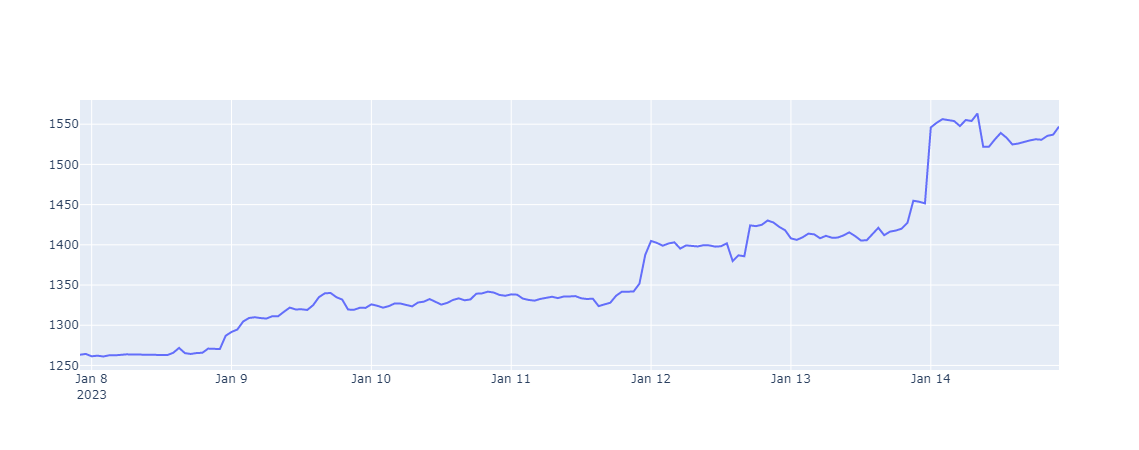

ETH-USD 3mo 1h
[*********************100%***********************]  1 of 1 completed


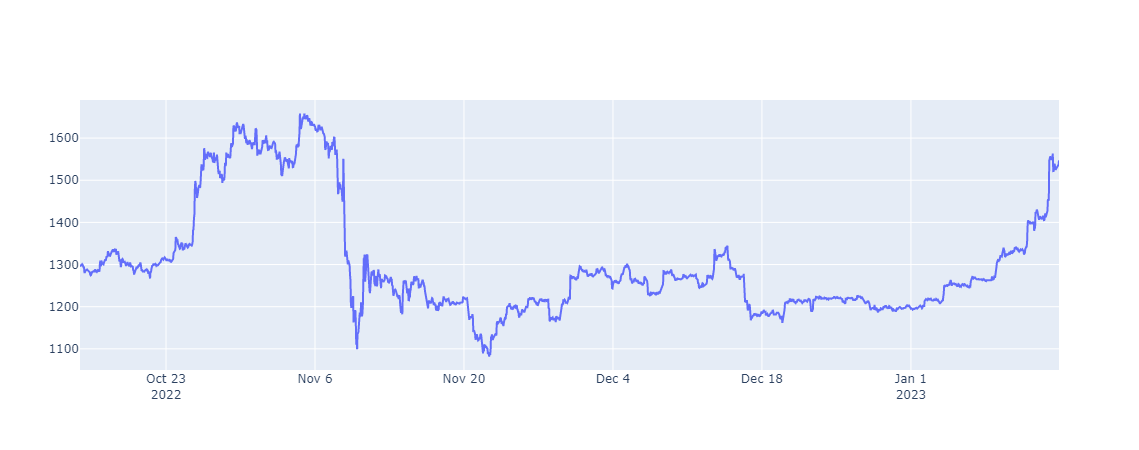

In [12]:
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

def getLine(df_input):
    x = df_input.index
    y = df_input.values
    fig = go.Figure(data=go.Scatter(x = x, y = y))
    fig.show()
    
#------------------------------------------------

#( getLine(getRates('ETH-USD',  '1d',  '1h')) )
( getLine(getRates('ETH-USD',  '1wk',  '1h')) )
( getLine(getRates('ETH-USD',  '3mo',  '1h')) )
#( getLine(getRates('ETH-USD',  '3y',  '1d')) )

In [13]:

html = dfx.to_html()
# Write the HTML to a file
with open('crypto_change.html', 'w') as f:
  f.write(html)

# Display the HTML in a web browser
from IPython.display import display, HTML
display(HTML(html))

,Crypto_Pair,10yr_d_CHG%,5yr_d_CHG%,3yr_d_CHG%,1yr_d_CHG%,3mo_h_CHG%,1mo_h_CHG%,1wk_h_CHG%,1dy_h_CHG%
0,BTC-USD,4476.8001,51.9842,137.1072,-51.4352,9.2495,17.3428,23.5317,-0.0780
1,ETH-USD,382.0681,13.1777,832.1058,-53.2665,19.4087,17.8999,22.4437,0.0597
2,BNB-USD,15200.6862,1366.0301,1732.0657,-37.8196,13.2051,13.6228,16.6758,1.1792
3,XRP-USD,81.0091,-78.8483,67.7438,-49.1574,-19.3906,2.0542,14.4558,-0.3662
4,BUSD-USD,-0.1298,-0.1298,-0.1846,0.0067,-0.0326,0.0424,-0.0016,0.0212
5,ADA-USD,990.0072,-56.4506,738.6462,-72.9357,-4.5032,13.3067,25.9876,-1.2437
6,DOGE-USD,6026.5018,641.9548,3409.7166,-52.7701,48.0387,-2.3035,20.2892,0.8140
7,MATIC-USD,22337.2314,22337.2314,6205.7021,-57.5678,26.5442,9.6771,22.9903,3.1242
8,SOL-USD,2306.1191,2306.1191,2306.1191,-84.3434,-23.4711,60.9746,75.0601,14.0996
9,DOT-USD,106.7528,106.7528,106.7528,-78.3638,-0.5689,15.0126,28.7050,8.5209


In [14]:
html = df_tmp_f.to_html()
# Write the HTML to a file
with open('crypto_bol.html', 'w') as f:
  f.write(html)

# Display the HTML in a web browser
from IPython.display import display, HTML
display(HTML(html))

,Crypto_Pair,Price,Bol_Up,Bol_Down,macd,signal,result
Date,,,,,,,
2023-01-08,BTC-USD,17091.144531,17164.458981,16568.825059,-15.72705,-74.442695,Buy
2023-01-09,BTC-USD,17196.554688,17279.089426,16599.361467,13.207424,-56.912671,Buy
2023-01-10,BTC-USD,17446.292969,17480.139736,16617.292741,55.648513,-34.400435,Buy
2023-01-11,BTC-USD,17934.896484,17961.651582,16441.968954,127.242826,-2.071782,Buy
2023-01-12,BTC-USD,18869.587891,18888.375787,16096.059481,256.447454,49.632065,Buy
2023-01-13,BTC-USD,19909.574219,20109.574762,15719.890639,437.715545,127.248761,Buy
2023-01-14,BTC-USD,20930.261719,21442.462375,15522.769768,656.168858,233.03278,Buy
2023-01-08,ETH-USD,1287.359497,1305.828059,1196.288955,7.442582,-2.889198,Buy
2023-01-09,ETH-USD,1321.53894,1332.205954,1200.448866,13.161297,0.320901,Buy
